In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import doubletdetection
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))

In [2]:
adata_adult = sc.read_10x_h5('./Adult/filtered_feature_bc_matrix.h5',gex_only= True)
adata_neo = sc.read_10x_h5('./P5/filtered_feature_bc_matrix.h5',gex_only= True)
adata_adult.obs.index=['adult_'+x for x in adata_adult.obs.index]
adata_neo.obs.index=['neo_'+x for x in adata_neo.obs.index]
adata_neo.obs.index

Index(['neo_AAACCCAAGAACCCGA-1', 'neo_AAACCCAAGAATGTTG-1',
       'neo_AAACCCAAGAGCGACT-1', 'neo_AAACCCAAGAGTTCGG-1',
       'neo_AAACCCAAGATGGTCG-1', 'neo_AAACCCAAGCCGATTT-1',
       'neo_AAACCCAAGCCGCACT-1', 'neo_AAACCCAAGCGTGAAC-1',
       'neo_AAACCCAAGCTGACTT-1', 'neo_AAACCCAAGGCGTTAG-1',
       ...
       'neo_TTTGTTGGTTGGTACT-1', 'neo_TTTGTTGTCCCTCTAG-1',
       'neo_TTTGTTGTCCCTTTGG-1', 'neo_TTTGTTGTCCGGTTCT-1',
       'neo_TTTGTTGTCCTGTACC-1', 'neo_TTTGTTGTCCTTTGAT-1',
       'neo_TTTGTTGTCGCACGAC-1', 'neo_TTTGTTGTCGCTACGG-1',
       'neo_TTTGTTGTCTACTATC-1', 'neo_TTTGTTGTCTGGACTA-1'],
      dtype='object', length=30391)

In [6]:
def map_condition(index):
    if 'adu' in index:
        return 'Adult'
    else:
        return 'Neonatal'

In [7]:
adata = adata_neo
index = adata.obs.index
index = ['neo_'+x for x in adata_neo.obs.index]
adata.obs['Sample'] = map_condition(index)

In [8]:
adata_neo.obs

Sample
neo_AAACCCAAGAACCCGA-1  Neonatal
neo_AAACCCAAGAATGTTG-1  Neonatal
neo_AAACCCAAGAGCGACT-1  Neonatal
neo_AAACCCAAGAGTTCGG-1  Neonatal
neo_AAACCCAAGATGGTCG-1  Neonatal
...                          ...
neo_TTTGTTGTCCTTTGAT-1  Neonatal
neo_TTTGTTGTCGCACGAC-1  Neonatal
neo_TTTGTTGTCGCTACGG-1  Neonatal
neo_TTTGTTGTCTACTATC-1  Neonatal
neo_TTTGTTGTCTGGACTA-1  Neonatal

[30391 rows x 1 columns]

In [9]:
adatas = [adata_adult,adata_neo]
adata = sc.concat(adatas, merge="same")
adata

AnnData object with n_obs × n_vars = 68838 × 20907
    obs: 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_counts=10)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top = None, log1p=False, inplace=True)
sc.pl.violin(adata,['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save= "mergeqc1207.pdf")

In [11]:
sc.settings.set_figure_params(dpi_save=600, figsize = (4, 4))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
sc.pl.scatter(adata,x='total_counts', y='pct_counts_mt',ax=ax[0],show=False)
sc.pl.scatter(adata,x='total_counts', y='n_genes_by_counts',ax=ax[1],show=False)
plt.subplots_adjust(wspace=0.4)
plt.savefig('scattermerge1207.pdf')

In [12]:
chrx_genes = [x.strip() for x in open('./chrX_gene657.txt')]
chry_genes = [x.strip() for x in open('./chrY_gene57.txt')]
chrX_related_genes = [x for x in chrx_genes if x in adata.var_names]
chrY_related_genes = [x for x in chry_genes if x in adata.var_names]
adata.var['chrX'] = adata.var_names.isin(chrX_related_genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['chrX'], percent_top = None, log1p=False, inplace=True)
adata.var['chrY'] = adata.var_names.isin(chrY_related_genes)
sc.pp.calculate_qc_metrics(adata, qc_vars=['chrY'], percent_top = None, log1p=False, inplace=True)

In [13]:
sc.pl.violin(adata,['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_chrX','pct_counts_chrY'], jitter=0.4, multi_panel=True, save= "mergexy1207.pdf")

In [14]:
cell_cycle_genes = [x.strip() for x in open('./cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [15]:
adata

AnnData object with n_obs × n_vars = 66468 × 19094
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY'

In [17]:
results_file = './interged_unfiltered1207.h5ad'
adata.write(results_file)

In [19]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)

In [20]:
doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

2022-12-08 10:19:12.693308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public/home/zhaox/anaconda3/envs/jupyter/lib:/opt/OpenBLAS/lib
2022-12-08 10:19:12.693361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
doublet_score = clf.doublet_score()

In [22]:
adata.obs["doublet"] = doublets
adata.obs["doublet_score"] = doublet_score

In [23]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 1, :]
adata = adata[adata.obs.doublet_score < 60, :]
results_file = './interged_processed_unlog1207.h5ad'
adata.write(results_file)

In [24]:
adata

View of AnnData object with n_obs × n_vars = 59171 × 19094
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY'

Doublet Detection (去除双细胞作图)

In [25]:
f = doubletdetection.plot.convergence(clf, save='convergence_test1207.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

In [26]:
adata_doublt = adata
##这样adata仍是未log,regress的

In [27]:
sc.pp.normalize_total(adata_doublt)
sc.pp.log1p(adata_doublt)
sc.pp.highly_variable_genes(adata_doublt)
sc.tl.pca(adata_doublt)
sc.pp.neighbors(adata_doublt)
sc.tl.umap(adata_doublt)

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
adata

AnnData object with n_obs × n_vars = 59171 × 19094
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
sc.pl.umap(adata, color=["doublet", "doublet_score"], save='mergeqc_doublet1207.pdf')

In [30]:
sc.pl.violin(adata, "doublet_score", save='mergrvio_doublet1207.pdf')
f3 = doubletdetection.plot.threshold(clf, save='mergethresholdtest1207.pdf', show=True, p_step=6)

cell cycle(作图)

In [31]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase',save= "mergecellcycle1207.pdf")

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save= ".findhvg.pdf")
adata.raw = adata ##You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata = adata[:, adata.var.highly_variable]

In [33]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [34]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save= "merge1207.pdf")

In [36]:
%%time
sc.external.pp.bbknn(adata, batch_key='Sample')

CPU times: user 6.89 s, sys: 446 ms, total: 7.34 s
Wall time: 7.49 s


In [37]:
adata

AnnData object with n_obs × n_vars = 59171 × 3318
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [31]:
adata.obs.groupby('Sample').count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
Sample                                                                
Adult       24759              24759         24759            24759   
Neonatal    25525              25525         25525            25525   

          pct_counts_mt  total_counts_chrX  pct_counts_chrX  \
Sample                                                        
Adult             24759              24759            24759   
Neonatal          25525              25525            25525   

          total_counts_chrY  pct_counts_chrY  S_score  G2M_score  phase  \
Sample                                                                    
Adult                 24759            24759    24759      24759  24759   
Neonatal              25525            25525    25525      25525  25525   

          doublet  doublet_score  leiden  
Sample                                    
Adult       24759          24759   24759  
Neonatal    25525          25525   25525

In [32]:
adata.layers['counts'] = adata.X.copy()

In [39]:
adata.obs.head()

Sample  n_genes  n_genes_by_counts  total_counts  \
adult_AAACCCAAGACCATTC-1  Adult     1185               1185        2223.0   
adult_AAACCCAAGACGAAGA-1  Adult      931                931        1569.0   
adult_AAACCCAAGAGCGACT-1  Adult     1266               1266        2655.0   
adult_AAACCCAAGATGTAGT-1  Adult     2978               2978        9340.0   
adult_AAACCCAAGCCGCTTG-1  Adult      628                628         759.0   

                          total_counts_mt  pct_counts_mt  total_counts_chrX  \
adult_AAACCCAAGACCATTC-1              0.0       0.000000               63.0   
adult_AAACCCAAGACGAAGA-1              1.0       0.063735               56.0   
adult_AAACCCAAGAGCGACT-1              1.0       0.037665               84.0   
adult_AAACCCAAGATGTAGT-1              0.0       0.000000               44.0   
adult_AAACCCAAGCCGCTTG-1              0.0       0.000000               15.0   

                          pct_counts_chrX  total_counts_chrY  pct_counts_chrY  \
adult_AAACCCAAGACCATTC-1         2.834008                3.0         0.134953   
adult_AAACCCAAGACGAAGA-1         3.569152                4.0         0.254939   
adult_AAACCCAAGAGCGACT-1         3.163842                8.0         0.301318   
adult_AAACCCAAGATGTAGT-1         0.471092                5.0         0.053533   
adult_AAACCCAAGCCGCTTG-1         1.976285                0.0         0.000000   

                           S_score  G2M_score phase  doublet  doublet_score  \
adult_AAACCCAAGACCATTC-1  0.029769  -0.078846     S      0.0   3.945989e-54   
adult_AAACCCAAGACGAAGA-1 -0.041627   0.088205   G2M      0.0   4.205109e-95   
adult_AAACCCAAGAGCGACT-1 -0.106342   0.071795   G2M      0.0   5.867091e+01   
adult_AAACCCAAGATGTAGT-1 -0.017369   0.950641   G2M      0.0   2.749409e+01   
adult_AAACCCAAGCCGCTTG-1 -0.018204   0.008590   G2M      0.0   1.402528e-70   

                         leiden  
adult_AAACCCAAGACCATTC-1     10  
adult_AAACCCAAGACGAAGA-1      1  
adult_AAACCCAAGAGCGACT-1      1  
adult_AAACCCAAGATGTAGT-1      6  
adult_AAACCCAAGCCGCTTG-1      9

In [40]:
adata

AnnData object with n_obs × n_vars = 59171 × 3318
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [47]:
sc.external.pp.bbknn(adata, batch_key='Sample') 

In [43]:
pip install bbknn

Note: you may need to restart the kernel to use updated packages.


In [35]:
import bbknn

In [48]:
sc.tl.umap(adata)

In [41]:
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata,color=['Sample', 'leiden'], legend_loc= "right margin", save= "merge1207bbknn.pdf")

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save="merged1207.pdf")

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFram

In [44]:
results_file = './interged_filtered_unannotation1207.h5ad'
adata.write(results_file)

In [45]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
adata.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    
    {group + '_' + key: result[key][group]    
    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("diff_rank_genes_groups_interged1207.csv")

In [46]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0             1       2         3       4             5            6  \
0   COL1A1          PTMA  CXCL12       CLU  CLEC3B          IGF1   C2H11orf91   
1  SELENOP  LOC100521680  COL3A1  SERPINA5  TM4SF1  LOC110256043     FANCD2OS   
2   COL3A1          SRGN  COL1A2       AMH   APOA1           PTN      SPATA16   
3      DCN      HSP90AA1     DCN      INHA  CLEC2B           C4A  C12H17orf64   
4   COL1A2          EIF1  COL4A1    COL9A2   RAMP2         PTGDS        LRRD1   

         7       8       9  ...      31      32            33            34  \
0     CAV1  TM4SF1    YBX1  ...  COL1A1  FAM24B        TM4SF1  LOC100736878   
1  GPIHBP1   PTPRB    YBX3  ...  COL1A2   LYZL4  LOC102161418          RPS8   
2   CAVIN2   ROBO4   FSIP2  ...   SFRP1   ACRV1       TSC22D1         RPS19   
3   CLEC3B   CYYR1  SPINK2  ...  COL5A2  FNDC11          UTRN         RPS3A   
4   CLEC2B   MYCT1   GSTM3  ...   SPARC  SPACA7         SOX17         RPL28   

             35            36            37    38       39     40  
0          CTSS    C9H1orf186  LOC100625564  TPT1     G0S2  RPS3A  
1         PLAC8  LOC100627879         PROK2  PTMA   SAMSN1   CTSC  
2          CST3  LOC110260659       PRPS1L1  SRGN  PHACTR1   TPT1  
3  LOC100523213           REL  LOC100525597  EIF1    CXCL8   RPS5  
4  LOC100736878          SRGN        SLC9C1   UBB   TYROBP   CCR7  

[5 rows x 41 columns]

In [7]:
pip install scipy==1.10.1

  Using cached scipy-1.10.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.4.9 requires numpy>=1.21, but you have numpy 1.20.3 which is incompatible.
jax 0.4.9 requires numpy>=1.21, but you have numpy 1.20.3 which is incompatible.
cellphonedb 4.0.0 requires numpy>=1.21.6, but you have numpy 1.20.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install scanpy==1.9.3

  Using cached scanpy-1.9.3-py3-none-any.whl (2.0 MB)
  Attempting uninstall: scanpy
    Found existing installation: scanpy 1.9.1
    Uninstalling scanpy-1.9.1:
      Successfully uninstalled scanpy-1.9.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import bbknn
import scanorama
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
import scvelo as scv
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))

Global seed set to 0
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
2023-05-11 15:57:58.797137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public/home/zhaox/anaconda3/envs/jupyter/lib:/opt/OpenBLAS/lib


Running scvelo 0.2.4 (python 3.9.7) on 2023-05-11 15:58.


In [ ]:
# marker to annotation
marker_genes_dict = {
    'Macrophage': ['SLA-DQB1'],
    'T cells':['GPR183'],
    'B cells':['MZB1'],
    'Endothelial cells': ['VWF', 'PECAM1','TM4SF1','MMRN1'],
    'Peritubular myoid cells': ['MYH11','ACTA2'],
    'Sertoli cells': ['SOX9','AMH','INHA','FATE1','CITED1','CLU','INHA'],
    'Leydig cells': ['CYP17A1', 'CYP11A1'],
    'Spermatogonia': ['DAZL','DDX4','UTF1','UCHL1','DMRT1', 'SOHLH1','KIT','PIWIL2','STRA8'],
    'Spermatocytes':['SYCP1', 'SYCP2', 'SYCP3','SMC1B', 'TEX101', 'ZCWPW1','ADAM2'],
    'Round spermatids' : ['CLGN','DKKL1','PKD2L2','SPACA1','SPACA3','SPATA22'],
    'Elongating spermatids': ['PRM1', 'PRM2', 'TNP1', 'TNP2'],
}

In [2]:
adata = sc.read('/public/home/zhaox/pigscRNA-seq/interged_processed_unlog1207.h5ad')
adata

AnnData object with n_obs × n_vars = 59171 × 19094
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY'

In [3]:
sc.pp.filter_genes(adata, min_cells = 10)

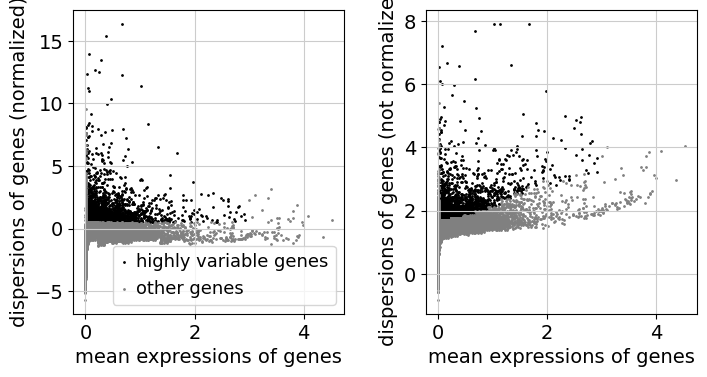

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save= "mergefindhvg1212.pdf")
adata.raw = adata ##You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata = adata[:, adata.var.highly_variable]

In [5]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [6]:
sc.tl.pca(adata, svd_solver='arpack')

In [7]:
adata

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
adata_scanorama = adata

In [8]:
adata_harmony = adata

In [9]:
adata_harmony

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [10]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata_harmony, 'Sample')

2023-05-11 16:07:07,594 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-11 16:08:05,206 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-11 16:08:05,486 - harmonypy - INFO - Iteration 1 of 10
2023-05-11 16:08:29,954 - harmonypy - INFO - Iteration 2 of 10
2023-05-11 16:08:57,209 - harmonypy - INFO - Converged after 2 iterations


In [11]:
adata_harmony

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

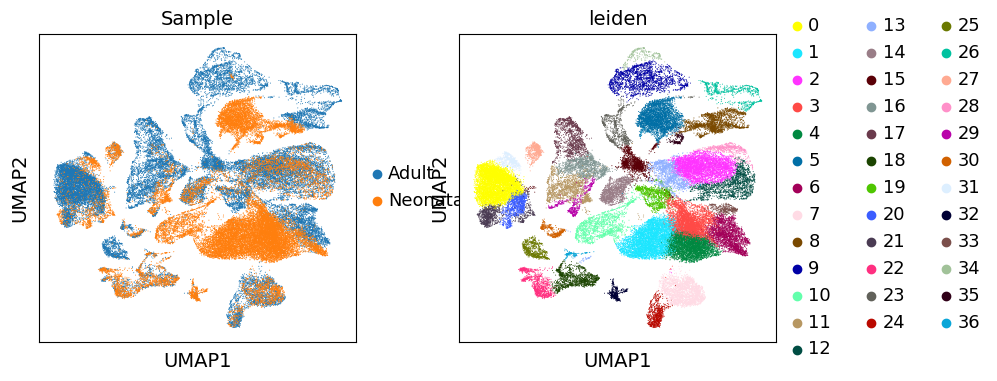

In [13]:
sc.pp.neighbors(adata_harmony, n_neighbors=10, n_pcs=40,use_rep = "X_pca_harmony")
sc.tl.umap(adata_harmony)
sc.tl.leiden(adata_harmony,resolution=1)
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata_harmony,color=['Sample', 'leiden'], legend_loc= "right margin", save= "merge1212.pdf")

In [14]:
adata

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Sample_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
# import scanpy.external as sce
# sce.pp.scanorama_integrate(adata, 'Sample')

[[0.         0.24472091]
 [0.         0.        ]]
Processing datasets Adult <=> Neonatal


In [18]:
# import bbknn
# bbknn.bbknn(adata_scanorama,batch_key='Sample',use_rep='X_pca')

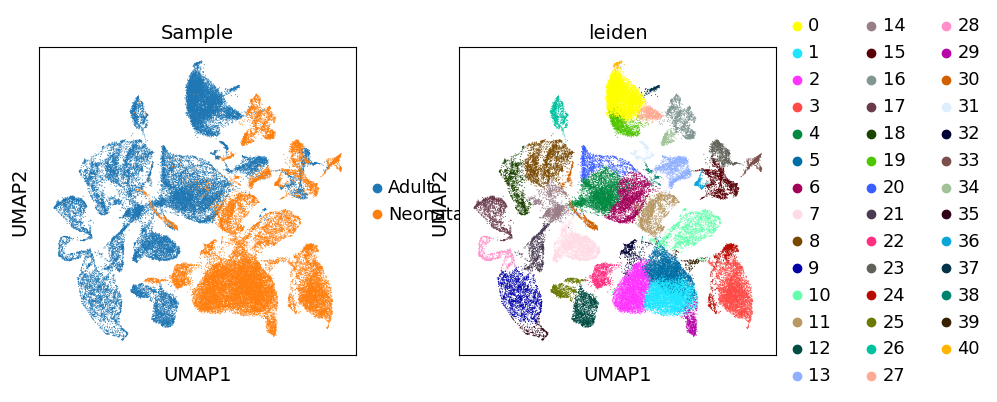

In [19]:
# sc.pp.neighbors(adata_scanorama, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_scanorama)
# sc.tl.leiden(adata_scanorama, resolution=1)
# sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
# sc.pl.umap(adata_scanorama,color=['Sample', 'leiden'], legend_loc= "right margin", save= "mergebbknn1212.pdf")

In [9]:
adata

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_scanorama'
    varm: 'PCs'

In [10]:
adata.obs.groupby('Sample').count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
Sample                                                                
Adult       32083              32083         32083            32083   
Neonatal    27088              27088         27088            27088   

          pct_counts_mt  total_counts_chrX  pct_counts_chrX  \
Sample                                                        
Adult             32083              32083            32083   
Neonatal          27088              27088            27088   

          total_counts_chrY  pct_counts_chrY  S_score  G2M_score  phase  \
Sample                                                                    
Adult                 32083            32083    32083      32083  32083   
Neonatal              27088            27088    27088      27088  27088   

          doublet  doublet_score  
Sample                            
Adult       32083          32083  
Neonatal    27088          27088

In [11]:
adata.obs

Sample  n_genes  n_genes_by_counts  total_counts  \
adult_AAACCCAAGACCATTC-1     Adult     1185               1185        2223.0   
adult_AAACCCAAGACGAAGA-1     Adult      931                931        1569.0   
adult_AAACCCAAGAGCGACT-1     Adult     1266               1266        2655.0   
adult_AAACCCAAGATGTAGT-1     Adult     2978               2978        9340.0   
adult_AAACCCAAGCCGCTTG-1     Adult      628                628         759.0   
...                            ...      ...                ...           ...   
neo_TTTGTTGTCCTGTACC-1    Neonatal     1913               1913        4195.0   
neo_TTTGTTGTCGCACGAC-1    Neonatal     4454               4454       10521.0   
neo_TTTGTTGTCGCTACGG-1    Neonatal     1974               1974        7257.0   
neo_TTTGTTGTCTACTATC-1    Neonatal     1946               1946        3738.0   
neo_TTTGTTGTCTGGACTA-1    Neonatal     2786               2786        6875.0   

                          total_counts_mt  pct_counts_mt  total_counts_chrX  \
adult_AAACCCAAGACCATTC-1              0.0       0.000000               63.0   
adult_AAACCCAAGACGAAGA-1              1.0       0.063735               56.0   
adult_AAACCCAAGAGCGACT-1              1.0       0.037665               84.0   
adult_AAACCCAAGATGTAGT-1              0.0       0.000000               44.0   
adult_AAACCCAAGCCGCTTG-1              0.0       0.000000               15.0   
...                                   ...            ...                ...   
neo_TTTGTTGTCCTGTACC-1                0.0       0.000000              138.0   
neo_TTTGTTGTCGCACGAC-1                0.0       0.000000              255.0   
neo_TTTGTTGTCGCTACGG-1                0.0       0.000000              328.0   
neo_TTTGTTGTCTACTATC-1                0.0       0.000000              140.0   
neo_TTTGTTGTCTGGACTA-1                0.0       0.000000              215.0   

                          pct_counts_chrX  total_counts_chrY  pct_counts_chrY  \
adult_AAACCCAAGACCATTC-1         2.834008                3.0         0.134953   
adult_AAACCCAAGACGAAGA-1         3.569152                4.0         0.254939   
adult_AAACCCAAGAGCGACT-1         3.163842                8.0         0.301318   
adult_AAACCCAAGATGTAGT-1         0.471092                5.0         0.053533   
adult_AAACCCAAGCCGCTTG-1         1.976285                0.0         0.000000   
...                                   ...                ...              ...   
neo_TTTGTTGTCCTGTACC-1           3.289631                5.0         0.119190   
neo_TTTGTTGTCGCACGAC-1           2.423724               19.0         0.180591   
neo_TTTGTTGTCGCTACGG-1           4.519774               25.0         0.344495   
neo_TTTGTTGTCTACTATC-1           3.745318                2.0         0.053505   
neo_TTTGTTGTCTGGACTA-1           3.127273               12.0         0.174545   

                           S_score  G2M_score phase  doublet  doublet_score  
adult_AAACCCAAGACCATTC-1  0.029769  -0.078846     S      0.0   3.945989e-54  
adult_AAACCCAAGACGAAGA-1 -0.041627   0.088205   G2M      0.0   4.205109e-95  
adult_AAACCCAAGAGCGACT-1 -0.106342   0.071795   G2M      0.0   5.867091e+01  
adult_AAACCCAAGATGTAGT-1 -0.017369   0.950641   G2M      0.0   2.749409e+01  
adult_AAACCCAAGCCGCTTG-1 -0.018204   0.008590   G2M      0.0   1.402528e-70  
...                            ...        ...   ...      ...            ...  
neo_TTTGTTGTCCTGTACC-1   -0.375308  -0.172051    G1      0.0   1.847410e-13  
neo_TTTGTTGTCGCACGAC-1   -0.183917  -0.145128    G1      0.0   3.453612e+01  
neo_TTTGTTGTCGCTACGG-1   -0.162999  -0.615513    G1      0.0   7.739418e-07  
neo_TTTGTTGTCTACTATC-1   -0.314350  -0.068590    G1      0.0   2.436721e+00  
neo_TTTGTTGTCTGGACTA-1   -0.458728  -0.084359    G1      0.0   4.272649e+01  

[59171 rows x 15 columns]

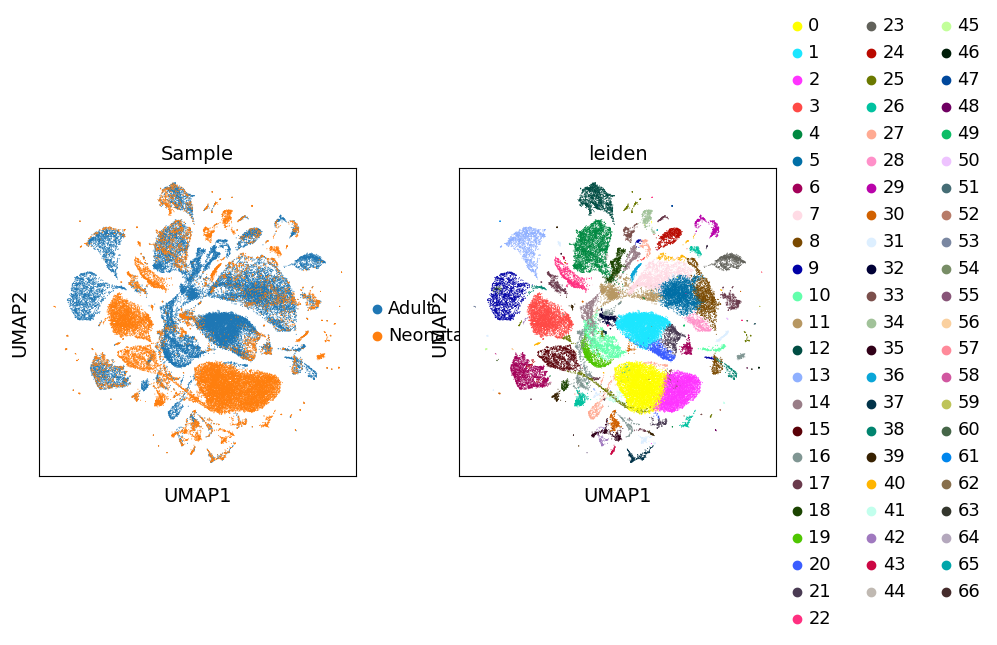

In [12]:
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40,use_rep = "X_scanorama")
# sc.tl.umap(adata)
# sc.tl.leiden(adata,resolution=1)
# sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
# sc.pl.umap(adata,color=['Sample', 'leiden'], legend_loc= "right margin", save= "merge1212.pdf")

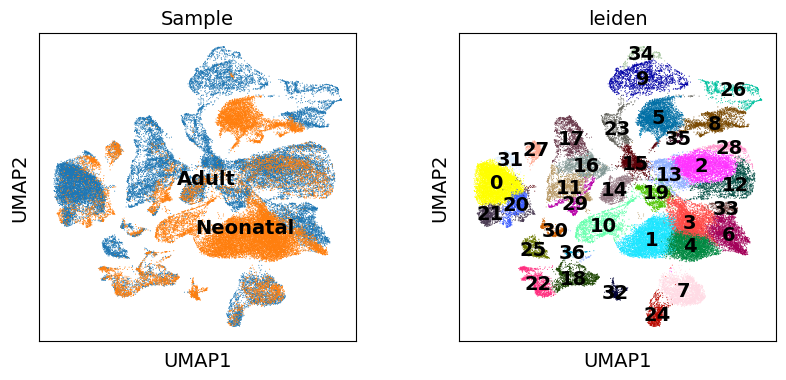

In [17]:
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata,color=['Sample', 'leiden'], legend_loc= "on data", save= "merge1212.pdf")

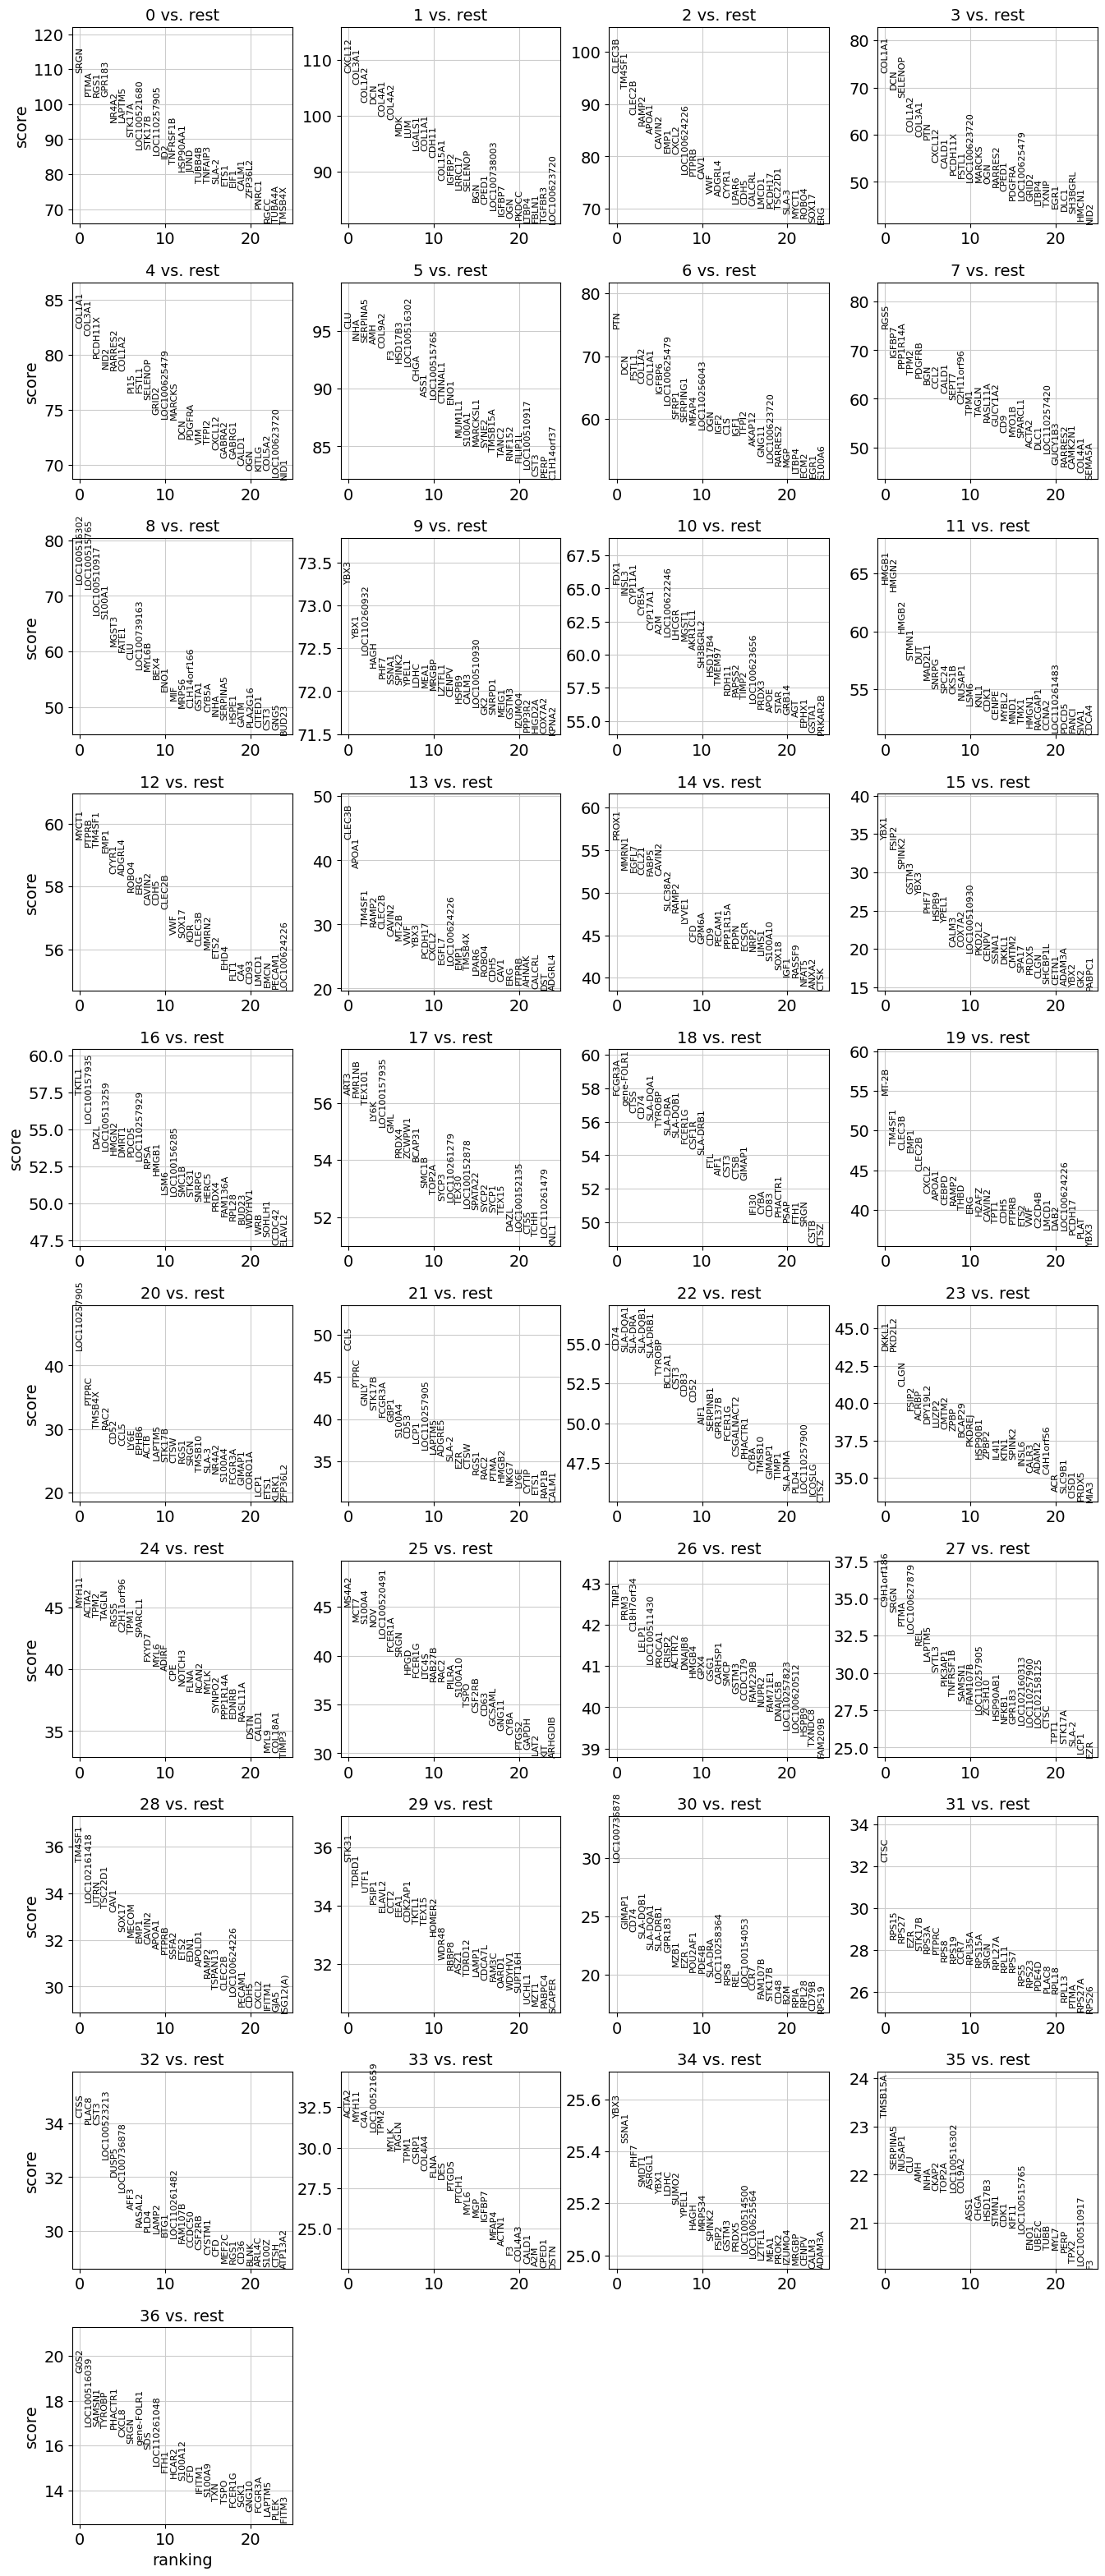

In [18]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save="mergemarker1212.pdf")

In [19]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
adata.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    
    {group + '_' + key: result[key][group]    
    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("diff_rank_genes_groups_interged1207.csv")

In [20]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

0        1             2             3             4  \
0           SRGN   CXCL12        CLEC3B        COL1A1        COL1A1   
1           PTMA   COL3A1        TM4SF1           DCN        COL3A1   
2           RGS1   COL1A2        CLEC2B       SELENOP       PCDH11X   
3         GPR183      DCN         RAMP2        COL1A2          NID2   
4          NR4A2   COL4A1         APOA1        COL3A1       RARRES2   
5         LAPTM5   COL4A2        CAVIN2           PTN        COL1A2   
6         STK17A      MDK          EMP1        CXCL12          PI15   
7   LOC100521680      LUM         CXCL2         CALD1         FSTL1   
8         STK17B   LGALS1  LOC100624226       PCDH11X       SELENOP   
9   LOC110257905   COL1A1         PTPRB         FSTL1         GRID2   
10           ID2    CDH11          CAV1  LOC100623720  LOC100625479   
11      TNFRSF1B  COL15A1           VWF        MARCKS        MARCKS   
12      HSP90AA1   IGFBP2        ADGRL4           OGN           DCN   
13          JUND   LRRC17         CYYR1       RARRES2        PDGFRA   
14        TUBB4B  SELENOP         LPAR6         CPED1           VIM   

               5             6           7             8             9  ...  \
0            CLU           PTN        RGS5  LOC100516302          YBX3  ...   
1           INHA           DCN      IGFBP7  LOC100515765          YBX1  ...   
2       SERPINA5         FSTL1    PPP1R14A  LOC100510917  LOC110260932  ...   
3            AMH        COL1A2        TPM2        S100A1          HAGH  ...   
4         COL9A2        COL1A1      PDGFRB         MGST3          PHF7  ...   
5             F3        IGFBP6         BGN         FATE1         SSNA1  ...   
6        HSD17B3  LOC100625479        CCL2           CLU        SPINK2  ...   
7   LOC100516302         SFRP1       CALD1  LOC100739163         YPEL1  ...   
8           CHGA      SERPING1       SEPT7         MYL6B          LDHC  ...   
9           ASS1         MFAP4  C2H11orf96          BEX4          MEA1  ...   
10  LOC100515765  LOC110256043        TPM1          ENO1         MRGBP  ...   
11       CTNNAL1           OGN       TAGLN           MIF        LZTFL1  ...   
12          ENO1          IGF2     RASL11A         MRPS6         CENPV  ...   
13        MUM1L1           C1S     GUCY1A2   C1H14orf166         HSPB9  ...   
14        S100A1          IGF1         CD9         GSTA1         CALM3  ...   

              27            28       29            30      31            32  \
0     C9H1orf186        TM4SF1    STK31  LOC100736878    CTSC          CTSS   
1           SRGN  LOC102161418    TDRD1        GIMAP1   RPS15         PLAC8   
2           PTMA          UTRN     UTF1          CD74   RPS27          CST3   
3   LOC100627879       TSC22D1    PSIP1      SLA-DQB1     EZR  LOC100523213   
4            REL          CAV1   ELAVL2      SLA-DQA1  STK17B         DUSP5   
5         LAPTM5         SOX17     CCT2      SLA-DRB1   RPS3A  LOC100736878   
6          SYTL3         MECOM     EEA1        GPR183   PTPRC          AFF3   
7        PIK3AP1          EMP1  CDK2AP1          MZB1    RPS8        RASAL2   
8       TNFRSF1B        CAVIN2    TKTL1           EZR   RPS19          PLD4   
9         SAMSN1         APOA1    TEX15       POU2AF1    CCR7         LAMP2   
10       FAM107B         PTPRB   HOMER2         PDE4B  RPL35A          BTG1   
11  LOC110257905         SSFA2    WDR48       SLA-DRA  RPS15A  LOC110261482   
12        ZC3H10          ETS2    RBBP8  LOC110258364    SRGN       FAM107B   
13      HSP90AB1          EDN1     ASZ1          RPS8  RPL27A        CCDC50   
14         NFKB1        APOLD1   TDRD12           REL   RPL11        CSF2RB   

              33      34            35            36  
0          ACTA2    YBX3       TMSB15A          G0S2  
1          MYH11   SSNA1      SERPINA5  LOC100516039  
2            C4A    PHF7        NUSAP1        SAMSN1  
3   LOC100521659   SMDT1           CLU        TYROBP  
4           TPM2  ASRGL1           AMH       PHACTR1  
5           MYLK  

In [22]:
# marker to annotation
marker_genes_dict = {
    'Macrophage': ['SLA-DQB1'],
    'T cells':['GPR183'],
    'B cells':['MZB1'],
    'Endothelial cells': ['VWF', 'PECAM1','TM4SF1','MMRN1'],
    'Peritubular myoid cells': ['MYH11','ACTA2'],
    'Sertoli cells': ['SOX9','AMH','INHA','FATE1','CITED1','CLU','INHA'],
    'Leydig cells': ['CYP17A1', 'CYP11A1','COL1A1','COL1A2','COL3A1','DCN'],
    'Spermatogonia': ['DAZL','DDX4','UTF1','UCHL1','DMRT1', 'SOHLH1','KIT','PIWIL2','STRA8'],
    'Spermatocytes':['SYCP1', 'SYCP2', 'SYCP3','SMC1B', 'TEX101', 'ZCWPW1','ADAM2'],
    'Round spermatids' : ['ACRV1','DKKL1','PKD2L2','SPACA1','SPACA3','SPATA22'],
    'Elongating spermatids': ['PRM1', 'PRM2', 'TNP1', 'TNP2'],
}

In [39]:
marker_genes_dict = {
    'Macrophage': ['CD74','TYROBP','SLA-DQB1','SLA-DRB1','SLA-DQA1'],
    'T cells':['ID2','RGS1'],
    'Endothelial cells': ['VWF', 'PECAM1','TM4SF1','CLEC3B','CDH5'],
    'Peritubular myoid cells': ['MYH11', 'MYL9','ACTA2'],
    'Sertoli cells': ['SOX9','AMH','CLU','INHA'],
    'Leydig cells': ['CYP17A1', 'CYP11A1','COL1A1','COL1A2','COL3A1','DCN'],
    'Undiff spermatogonia': ['UTF1', 'PIWIL4',],
    'Diff spermatogonia':['DMRT1', 'SOHLH1', 'MKI67','KIT','PIWIL2','UCHL1','STRA8'],
    'Spermatocytes':['SYCP1', 'SYCP2', 'SYCP3','SMC1B', 'TEX101', 'ZCWPW1','ADAM2'],
    'Round spermatids' : ['CLGN','DKKL1','YBX2','SPACA1'],
    'Elongating spermatids': ['PRM1', 'PRM2', 'TNP1', 'TNP2','ACRV1'],
}

categories: 0, 1, 2, etc.
var_group_labels: Macrophage, T cells, B cells, etc.


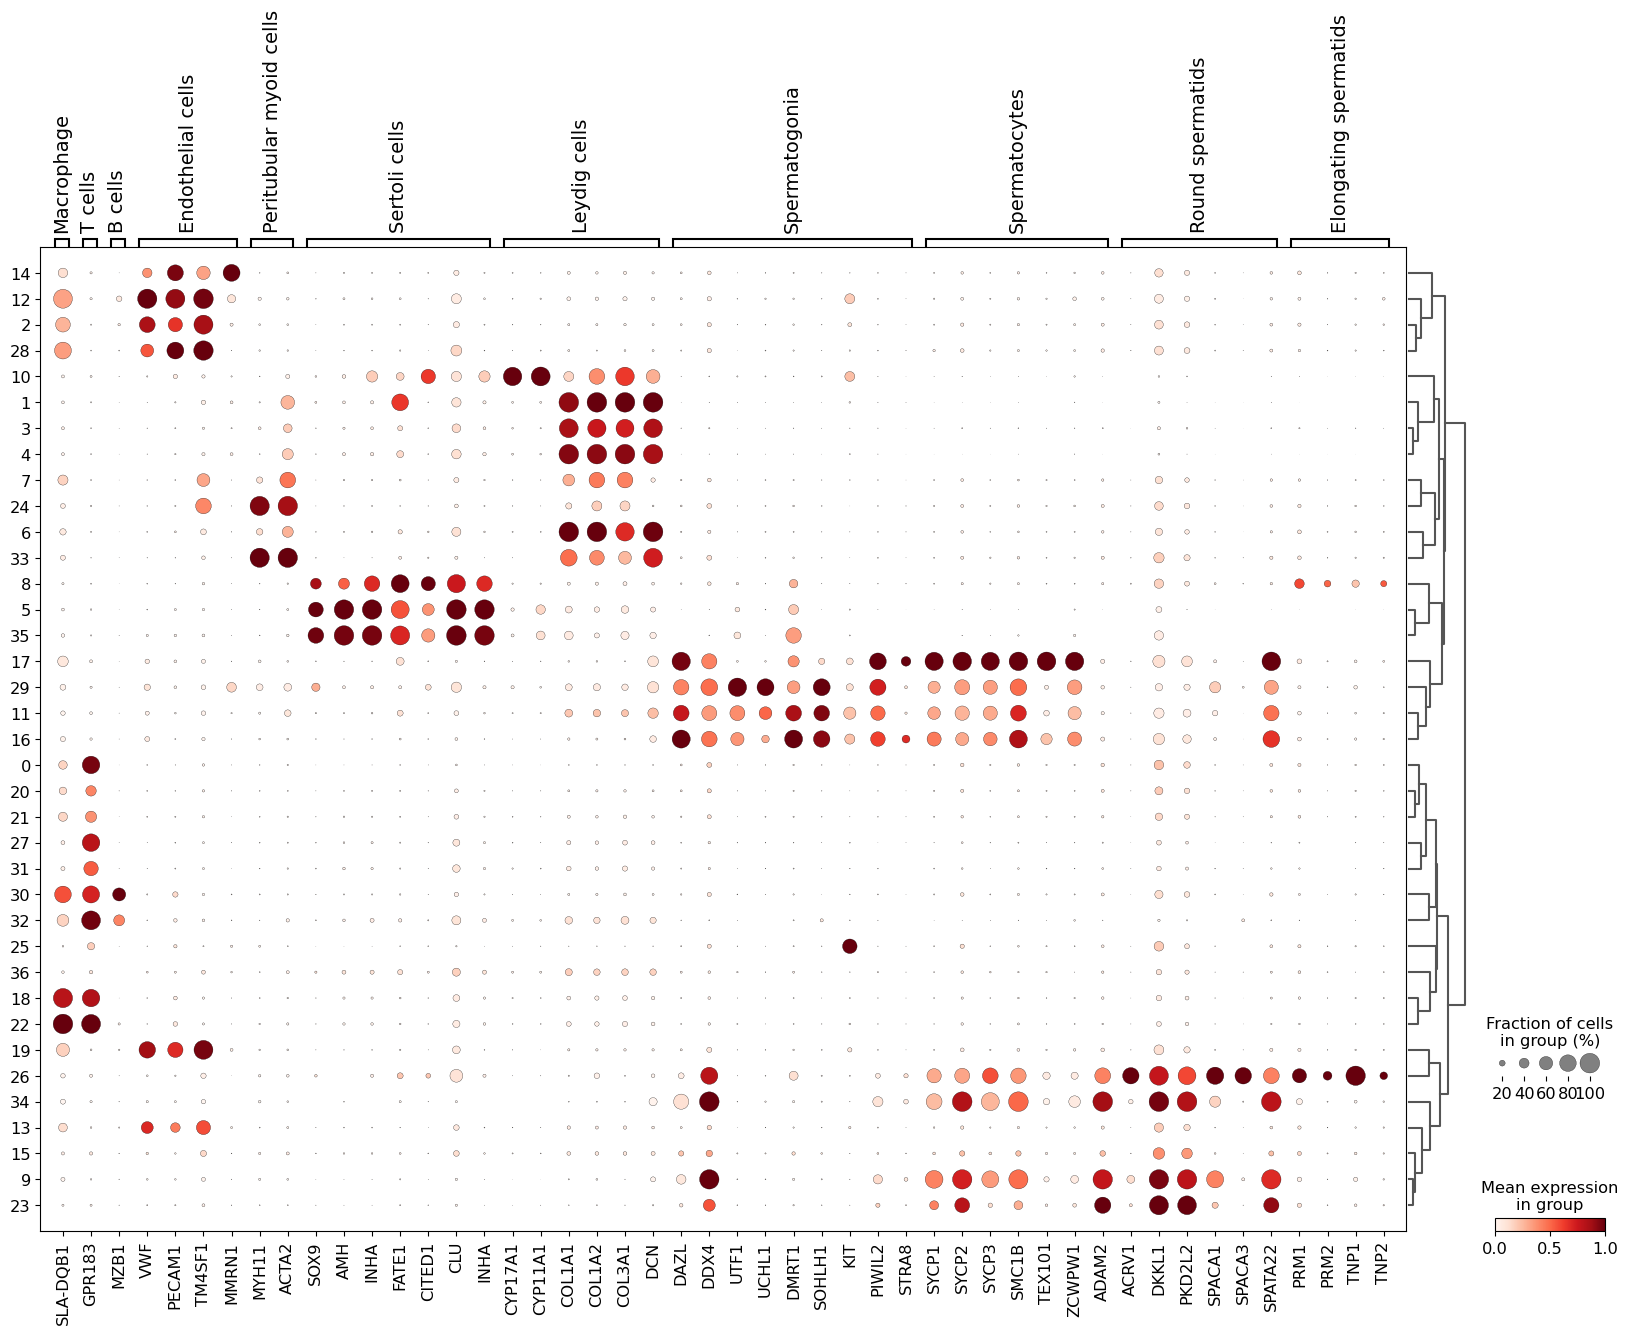

In [23]:
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', use_raw= True,standard_scale='var', dendrogram=True,save="interged1212.pdf")

In [ ]:
Immature Leydig cells      15451
Endothelial cells          10501
T cells                     9378
Sertoli cells               4678
Round spermatids            4595
Peritubular myoid cells     3110
Macrophage                  2446
spermatocytes               2207
Diff spermatogonia          2022
Leydig cells                1535
Elongating spermatids       1333
B cells                      837
KIT_spermatogonia            735
Undiff spermatogonia         343

In [25]:
cluster2annotation = {
     '0': 'T cells',
     '1': 'Immature Leydig cells',
     '2': 'Endothelial cells',
     '3': 'Immature Leydig cells',
     '4': 'Immature Leydig cells',
     '5': 'Sertoli cells',
     '6': 'Immature Leydig cells',
     '7': 'Peritubular myoid cells',
     '8': 'Sertoli cells',
     '9': 'Round spermatids',
     '10': 'Leydig cells',
     '11': 'Diff spermatogonia',
     '12': 'Endothelial cells',
     '13': 'Endothelial cells',
     '14': 'Endothelial cells',
     '15': 'unknown',
     '16': 'Diff spermatogonia',
     '17': 'Spermatocytes',
     '18': 'Macrophage',
     '19': 'Endothelial cells',
     '20': 'T cells',
     '21': 'T cells',
     '22': 'Macrophage',
     '23': 'Round spermatids',
     '24': 'Peritubular myoid cells',
     '25': 'KIT spermatogonia',
     '26': 'Elongating spermatids',
     '27': 'T cells',
     '28': 'Endothelial cells',
     '29': 'Undiff spermatogonia',     
     '30': 'B cells',
     '31': 'T cells',
     '32': 'T cells',
     '33': 'Peritubular myoid cells',
     '34': 'Round spermatids',
     '35': 'Sertoli cells',
     '36': 'unknown',
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

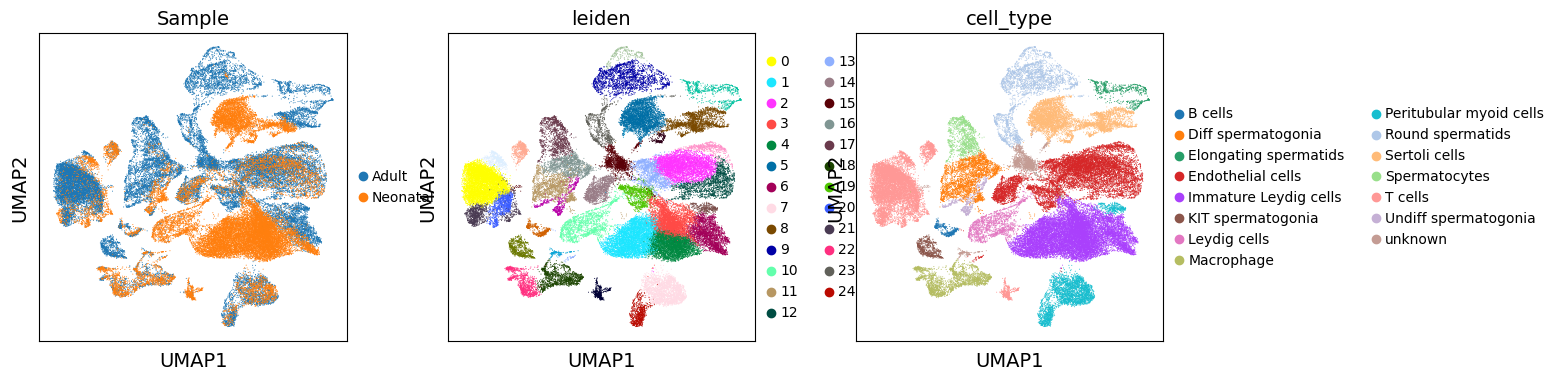

In [26]:
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata, color=['Sample','leiden','cell_type'], frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="celltype1212.pdf")

In [27]:
counts = adata.obs.cell_type.value_counts()
counts

Immature Leydig cells      15233
Endothelial cells          10364
T cells                     9738
Sertoli cells               5562
Peritubular myoid cells     3456
Round spermatids            2928
Diff spermatogonia          2918
Macrophage                  2281
unknown                     1583
Leydig cells                1561
Spermatocytes               1252
KIT spermatogonia            721
Elongating spermatids        640
Undiff spermatogonia         496
B cells                      438
Name: cell_type, dtype: int64

In [28]:
adata.obs['cell_type'].unique().to_list()

['Peritubular myoid cells',
 'T cells',
 'Round spermatids',
 'unknown',
 'Endothelial cells',
 'Sertoli cells',
 'Immature Leydig cells',
 'Diff spermatogonia',
 'Macrophage',
 'Spermatocytes',
 'Elongating spermatids',
 'KIT spermatogonia',
 'Undiff spermatogonia',
 'B cells',
 'Leydig cells']

In [29]:
original_order = ['Peritubular myoid cells','T cells','Round spermatids','unknown','Endothelial cells','Sertoli cells','Immature Leydig cells',
 'Diff spermatogonia','Macrophage','Spermatocytes','Elongating spermatids','KIT spermatogonia','Undiff spermatogonia','B cells','Leydig cells']
adata.obs['cell_type'] = adata.obs['cell_type'].cat.set_categories(['Macrophage', 'T cells','B cells','Endothelial cells', 'Peritubular myoid cells', 
                                                                    'Sertoli cells', 'Leydig cells','Immature Leydig cells', 'Undiff spermatogonia', 'Diff spermatogonia', 
                                                                    'KIT spermatogonia','Spermatocytes','Round spermatids','Elongating spermatids','unknown'])

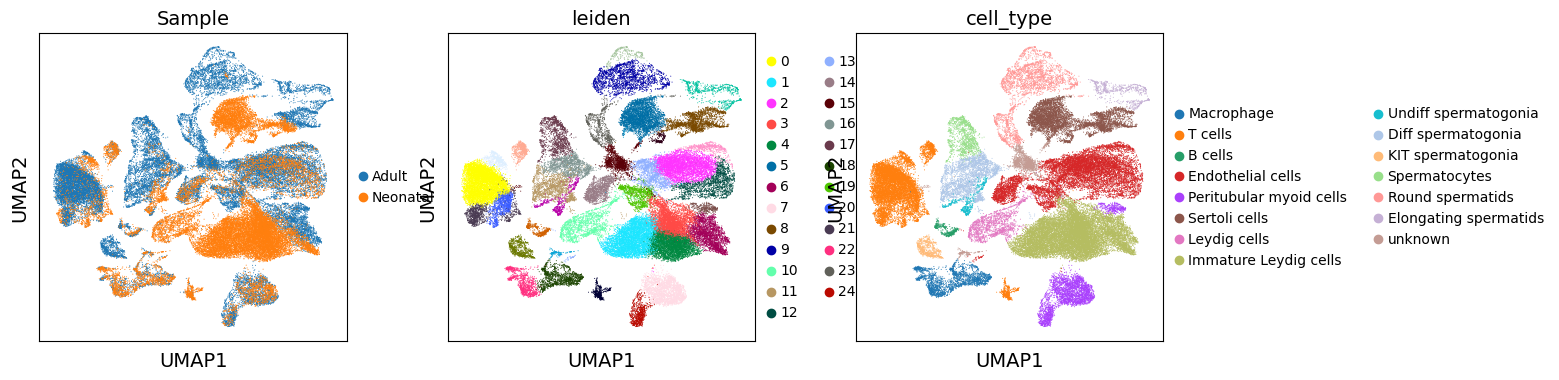

In [30]:
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata, color=['Sample','leiden','cell_type'], frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="celltype1212.pdf")

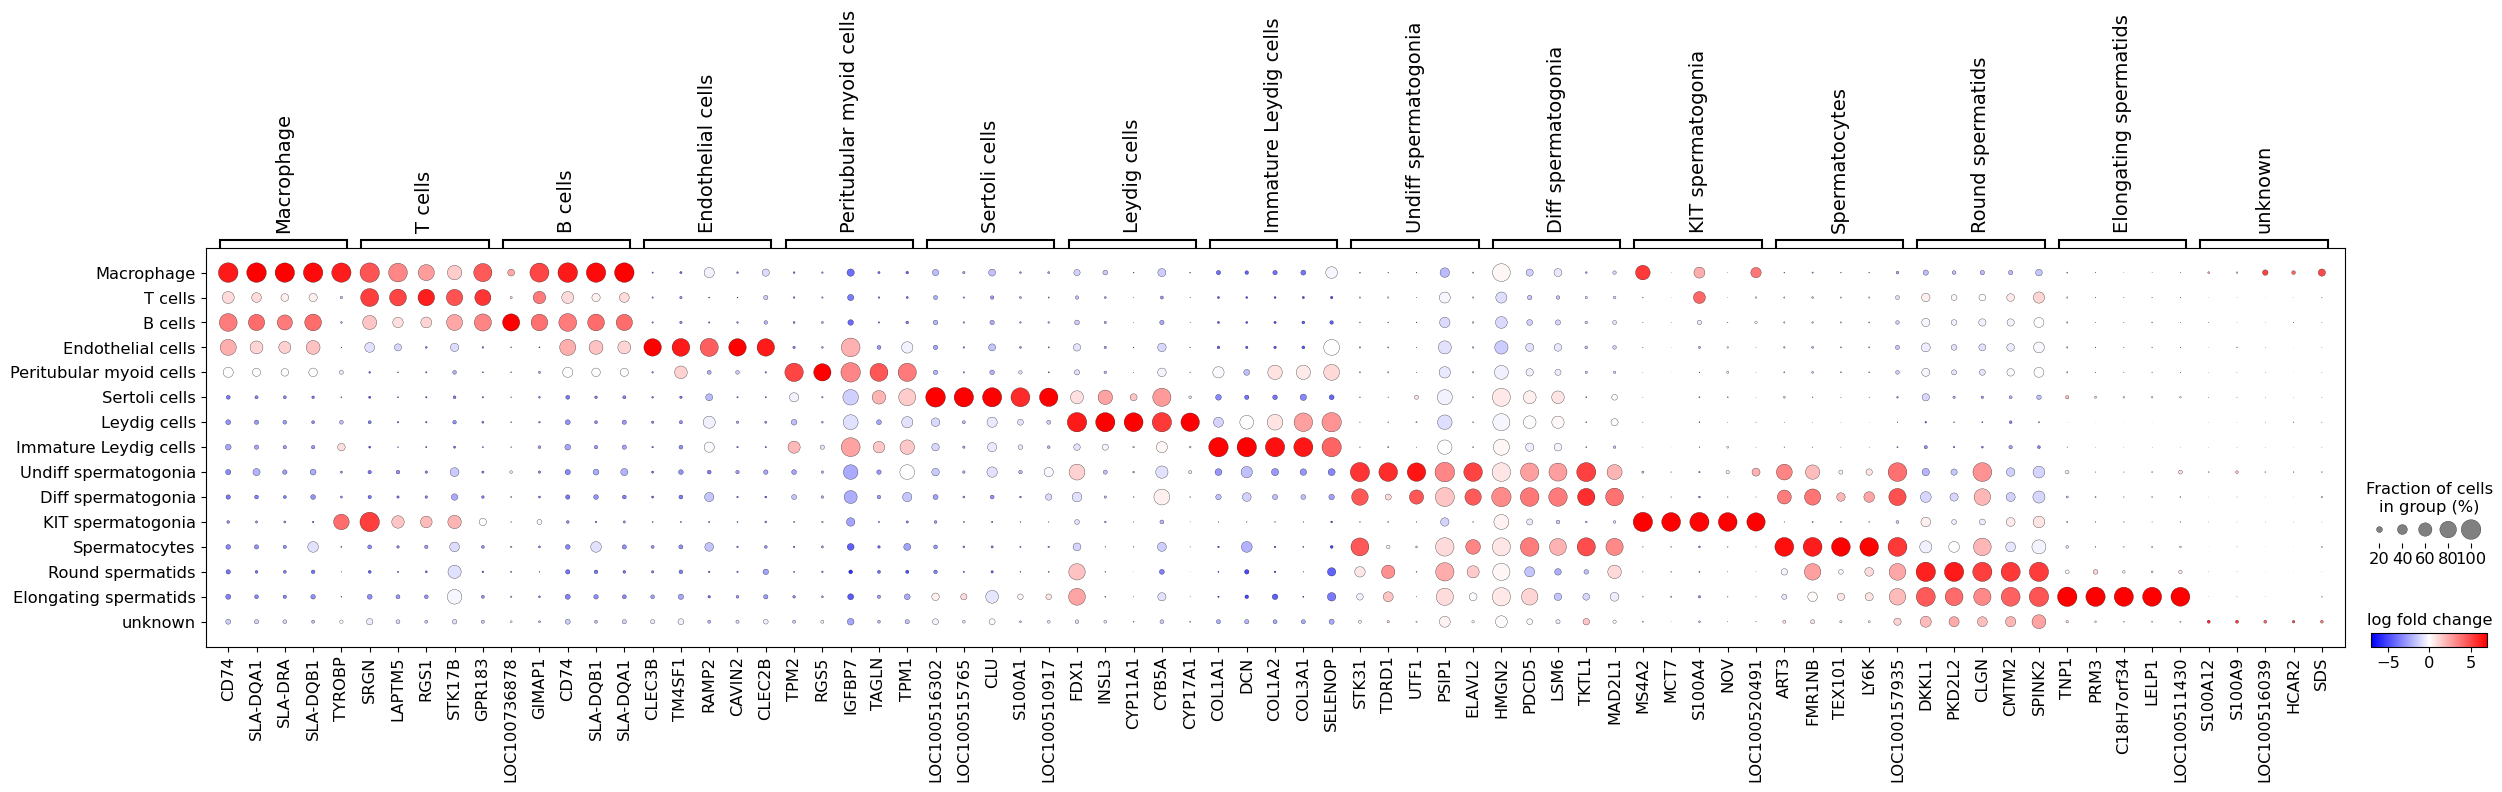

In [31]:
sc.tl.rank_genes_groups(adata, groupby='cell_type', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, values_to_plot='logfoldchanges',dendrogram=False, min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', save="intergednewmarkers1212.pdf")

In [12]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, values_to_plot='logfoldchanges',dendrogram=False, min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', save="intergednewmarkers1212.pdf")

In [32]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
adata.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    
    {group + '_' + key: result[key][group]    
    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("./figures/interged1212_diff_rank_genes_groups_celltype.csv")

In [33]:
results_file = './intergedbbknn_annotation1212.h5ad'
adata.write(results_file)

In [13]:
adata = sc.read('./intergedbbknn_annotation1212.h5ad',cache=True)
adata

AnnData object with n_obs × n_vars = 59171 × 2700
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [34]:
adata.obs['cell_type']

adult_AAACCCAAGACCATTC-1    Peritubular myoid cells
adult_AAACCCAAGACGAAGA-1                    T cells
adult_AAACCCAAGAGCGACT-1                    T cells
adult_AAACCCAAGATGTAGT-1           Round spermatids
adult_AAACCCAAGCCGCTTG-1                    unknown
                                     ...           
neo_TTTGTTGTCCTGTACC-1        Immature Leydig cells
neo_TTTGTTGTCGCACGAC-1         Undiff spermatogonia
neo_TTTGTTGTCGCTACGG-1                   Macrophage
neo_TTTGTTGTCTACTATC-1        Immature Leydig cells
neo_TTTGTTGTCTGGACTA-1        Immature Leydig cells
Name: cell_type, Length: 59171, dtype: category
Categories (15, object): ['Macrophage', 'T cells', 'B cells', 'Endothelial cells', ..., 'Spermatocytes', 'Round spermatids', 'Elongating spermatids', 'unknown']

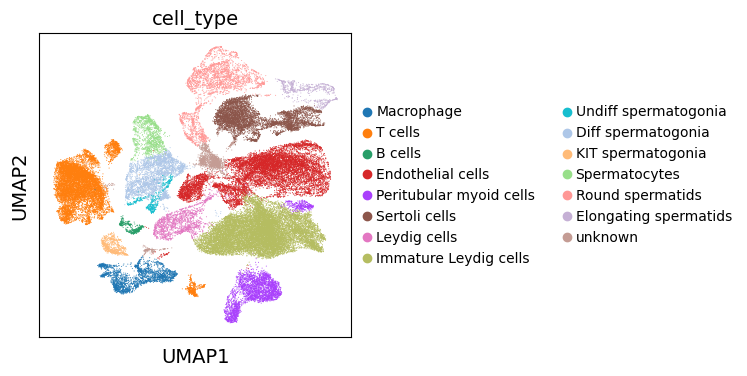

In [35]:
sc.pl.umap(adata, color=['cell_type'], frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="bbknncelltype1212.pdf")

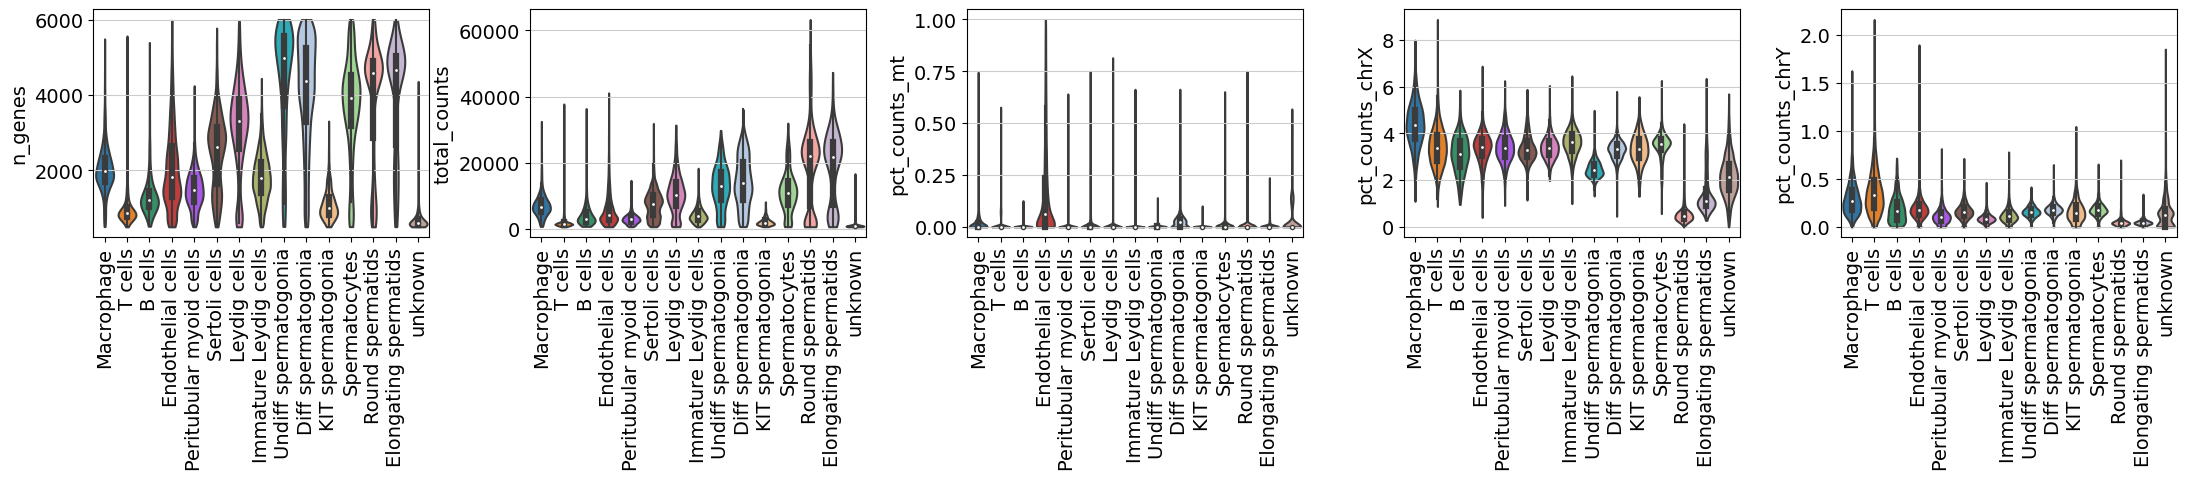

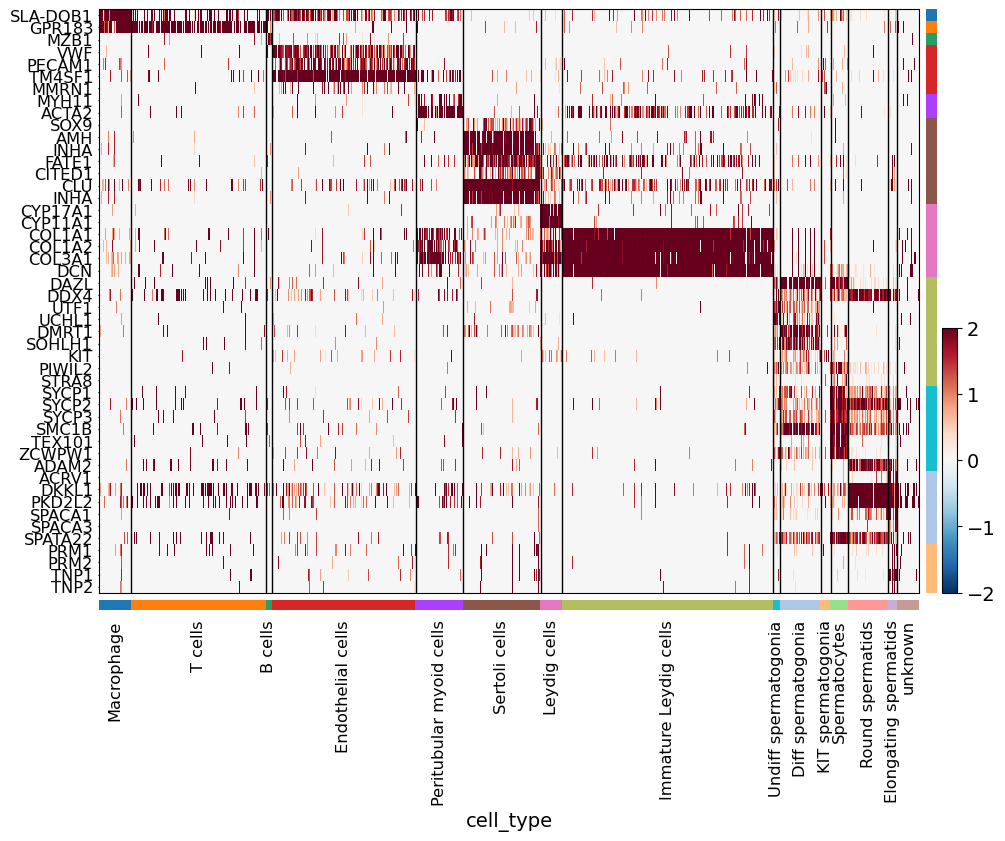

In [36]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['n_genes','total_counts', 'pct_counts_mt', 'pct_counts_chrX', 'pct_counts_chrY'], groupby='cell_type', rotation=90, stripplot=False, inner='box', save = "intergedmetrics1214.pdf")

sc.pl.rank_genes_groups_heatmap(adata, vmin=-2, vmax=2, cmap='RdBu_r', show=False,dendrogram=False, save = "fig1dinterged1214.pdf")
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8),save='intergedmarker1214.pdf')

In [37]:
sc.pl.rank_genes_groups_heatmap(adata, use_raw=True, vmin=-5, vmax=5,min_logfoldchange=2,groupby='cell_type', cmap='RdBu_r', show=False,dendrogram=False, save = "fig1intergeduseraw1221.pdf")

{'heatmap_ax': <AxesSubplot: >,
 'groupby_ax': <AxesSubplot: ylabel='cell_type'>,
 'gene_groups_ax': <AxesSubplot: >}

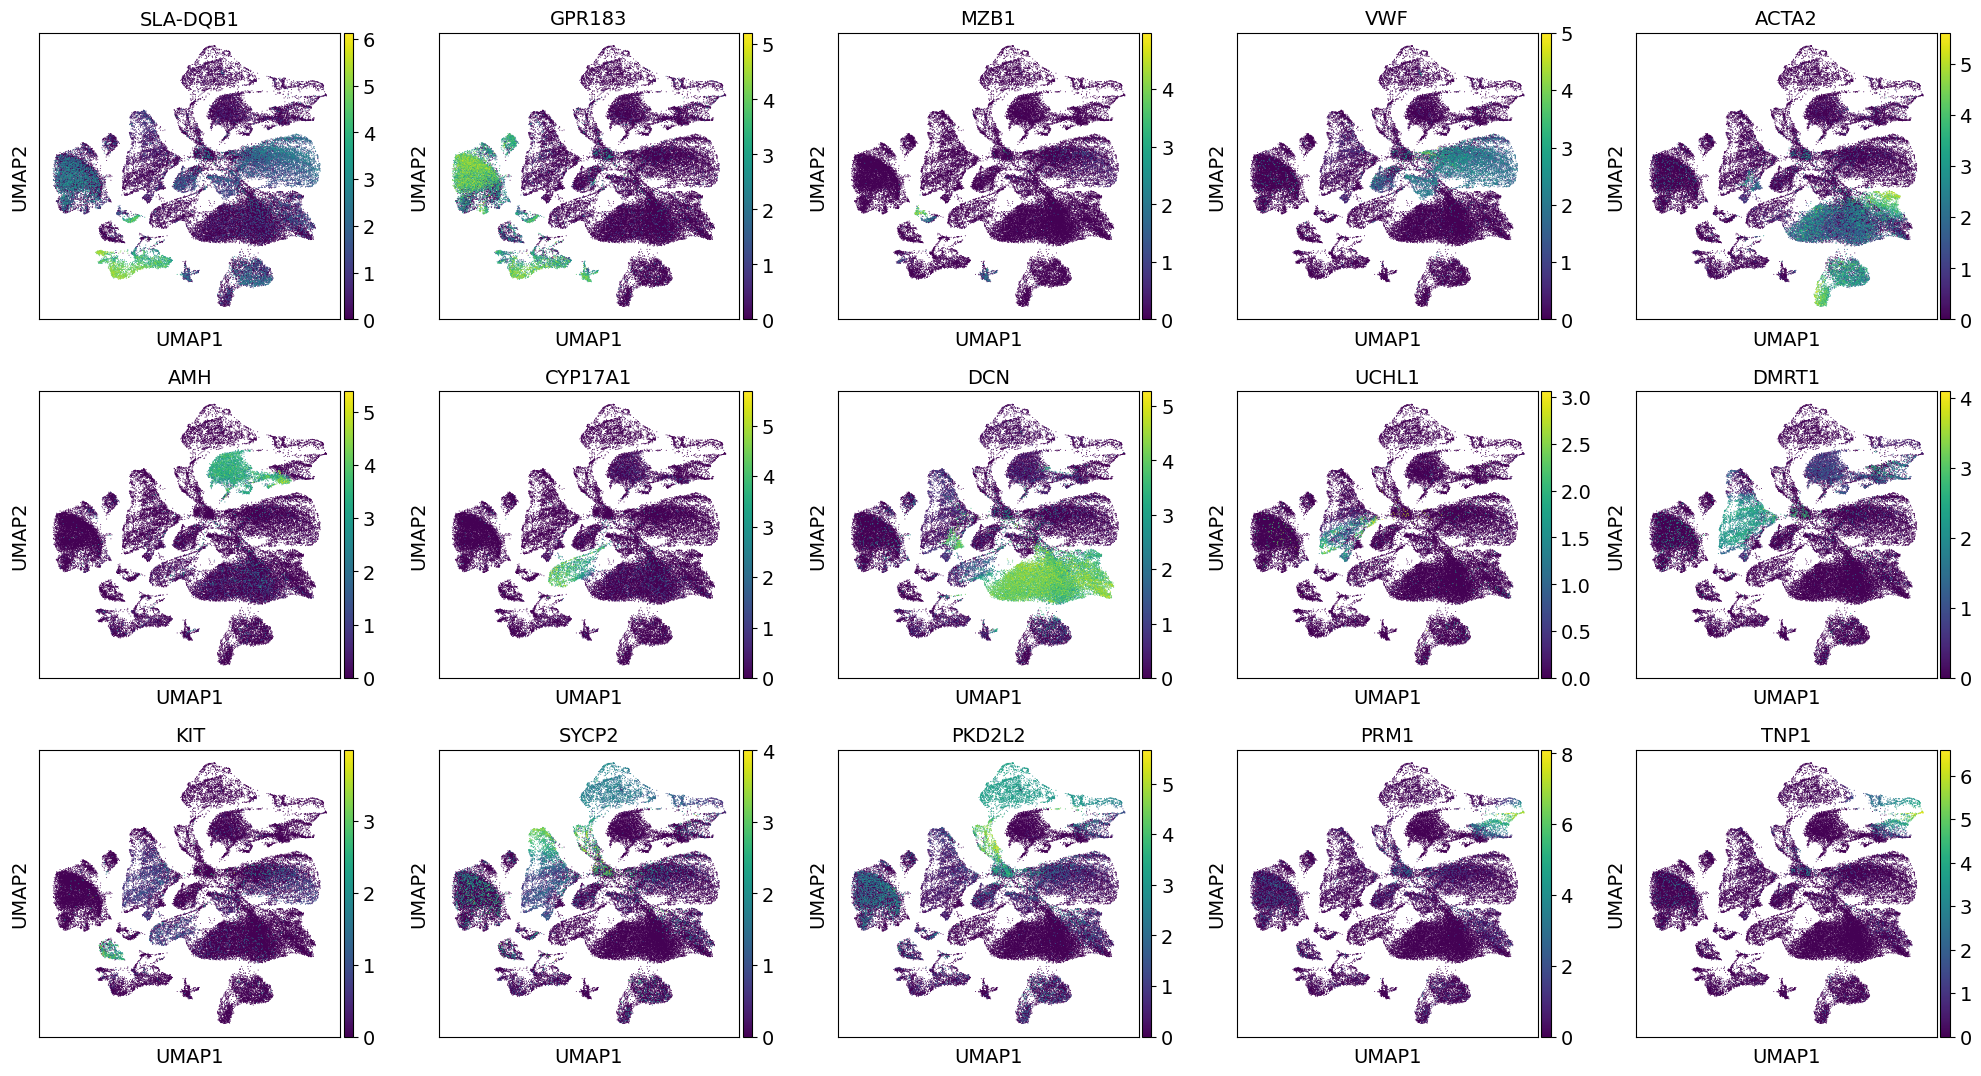

In [38]:
marker_genes = ["SLA-DQB1", "GPR183",'MZB1', "VWF", 'ACTA2', "AMH", "CYP17A1",'DCN','UCHL1','DMRT1','KIT',"SYCP2", "PKD2L2","PRM1","TNP1"]
sc.pl.umap(adata, color = marker_genes, ncols=5, save="intergedmks1221.pdf")

首先对细胞进行计数：

In [39]:
adata.obs.Sample.unique().tolist()

['Adult', 'Neonatal']

In [49]:
# adata = sc.read_h5ad('integrated.h5ad')
adata.obs.Sample.unique().tolist()

# 添加一列细胞的样本来源
def map_condition(x):
    if 'Adult' in x:
        return 'Adult'
    else:
        return 'Neonatal'

adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

Sample  n_genes  n_genes_by_counts  total_counts  \
adult_AAACCCAAGACCATTC-1     Adult     1185               1185        2223.0   
adult_AAACCCAAGACGAAGA-1     Adult      931                931        1569.0   
adult_AAACCCAAGAGCGACT-1     Adult     1266               1266        2655.0   
adult_AAACCCAAGATGTAGT-1     Adult     2978               2978        9340.0   
adult_AAACCCAAGCCGCTTG-1     Adult      628                628         759.0   
...                            ...      ...                ...           ...   
neo_TTTGTTGTCCTGTACC-1    Neonatal     1913               1913        4195.0   
neo_TTTGTTGTCGCACGAC-1    Neonatal     4454               4454       10521.0   
neo_TTTGTTGTCGCTACGG-1    Neonatal     1974               1974        7257.0   
neo_TTTGTTGTCTACTATC-1    Neonatal     1946               1946        3738.0   
neo_TTTGTTGTCTGGACTA-1    Neonatal     2786               2786        6875.0   

                          total_counts_mt  pct_counts_mt  total_counts_chrX  \
adult_AAACCCAAGACCATTC-1              0.0       0.000000               63.0   
adult_AAACCCAAGACGAAGA-1              1.0       0.063735               56.0   
adult_AAACCCAAGAGCGACT-1              1.0       0.037665               84.0   
adult_AAACCCAAGATGTAGT-1              0.0       0.000000               44.0   
adult_AAACCCAAGCCGCTTG-1              0.0       0.000000               15.0   
...                                   ...            ...                ...   
neo_TTTGTTGTCCTGTACC-1                0.0       0.000000              138.0   
neo_TTTGTTGTCGCACGAC-1                0.0       0.000000              255.0   
neo_TTTGTTGTCGCTACGG-1                0.0       0.000000              328.0   
neo_TTTGTTGTCTACTATC-1                0.0       0.000000              140.0   
neo_TTTGTTGTCTGGACTA-1                0.0       0.000000              215.0   

                          pct_counts_chrX  total_counts_chrY  pct_counts_chrY  \
adult_AAACCCAAGACCATTC-1         2.834008                3.0         0.134953   
adult_AAACCCAAGACGAAGA-1         3.569152                4.0         0.254939   
adult_AAACCCAAGAGCGACT-1         3.163842                8.0         0.301318   
adult_AAACCCAAGATGTAGT-1         0.471092                5.0         0.053533   
adult_AAACCCAAGCCGCTTG-1         1.976285                0.0         0.000000   
...                                   ...                ...              ...   
neo_TTTGTTGTCCTGTACC-1           3.289631                5.0         0.119190   
neo_TTTGTTGTCGCACGAC-1           2.423724               19.0         0.180591   
neo_TTTGTTGTCGCTACGG-1           4.519774               25.0         0.344495   
neo_TTTGTTGTCTACTATC-1           3.745318                2.0         0.053505   
neo_TTTGTTGTCTGGACTA-1           3.127273               12.0         0.174545   

                           S_score  G2M_score phase  doublet  doublet_score  \
adult_AAACCCAAGACCATTC-1  0.029769  -0.078846     S      0.0   3.945989e-54   
adult_AAACCCAAGACGAAGA-1 -0.041627   0.088205   G2M      0.0   4.205109e-95   
adult_AAACCCAAGAGCGACT-1 -0.106342   0.071795   G2M      0.0   5.867091e+01   
adult_AAACCCAAGATGTAGT-1 -0.017369   0.950641   G2M      0.0   2.749409e+01   
adult_AAACCCAAGCCGCTTG-1 -0.018204   0.008590   G2M      0.0   1.402528e-70   
...                            ...        ...   ...      ...            ...   
neo_TTTGTTGTCCTGTACC-1   -0.375308  -0.172051    G1      0.0   1.847410e-13   
neo_TTTGTTGTCGCACGAC-1   -0.183917  -0.145128    G1      0.0   3.453612e+01   
neo_TTTGTTGTCGCTACGG-1   -0.162999  -0.615513    G1      0.0   7.739418e-07   
neo_TTTGTTGTCTACTATC-1   -0.314350  -0.068590    G1      0.0   2.436721e+00   
neo_TTTGTTGTCTGGACTA-1   -0.458728  -0.084359    G1      0.0   4.272649e+01   

                         leiden                cell_type condition  
adult_AAACCCAAGACCATTC-1      7  Peritubular myoid cells     Adult  
adult_AAACCCAAGACGAAGA-1      0                  T cells  

In [51]:
# 每个样本中的细胞数统计
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

# {'C51ctr': 10934, 'C52ctr': 3967, 'C53ctr': 6076, 'C54ctr': 3860, 'C55ctr': 5110, 'C56ctr': 3609, 'C57ctr': 4307, 'L01cov': 2737,'L03cov': 3604, 'L04cov': 3056, 'L04covaddon': 4073, 'L05cov': 2435, 'L06cov': 5657, 'L07cov': 4217, 'L08cov': 3473, 'L09cov': 3075, 'L10cov': 2713, 'L11cov': 2531, 'L12cov': 3259, 'L13cov': 4244, 'L15cov': 3516, 'L16cov': 1600, 'L17cov': 3937, 'L18cov': 2392, 'L19cov': 2135, 'L21cov': 2961, 'L22cov': 5786}

cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell_type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

Sample condition                cell_type  n_genes
0      Adult     Adult               Macrophage      892
1      Adult     Adult                  T cells     7851
2      Adult     Adult                  B cells      313
3      Adult     Adult        Endothelial cells     7950
4      Adult     Adult  Peritubular myoid cells     2398
5      Adult     Adult            Sertoli cells     1046
6      Adult     Adult             Leydig cells       57
7      Adult     Adult    Immature Leydig cells     2126
8      Adult     Adult     Undiff spermatogonia      256
9      Adult     Adult       Diff spermatogonia     2437
10     Adult     Adult        KIT spermatogonia      714
11     Adult     Adult            Spermatocytes     1210
12     Adult     Adult         Round spermatids     2896
13     Adult     Adult    Elongating spermatids      640
14     Adult     Adult                  unknown     1297
15  Neonatal  Neonatal               Macrophage     1389
16  Neonatal  Neonatal                  T cells     1887
17  Neonatal  Neonatal                  B cells      125
18  Neonatal  Neonatal        Endothelial cells     2414
19  Neonatal  Neonatal  Peritubular myoid cells     1058
20  Neonatal  Neonatal            Sertoli cells     4516
21  Neonatal  Neonatal             Leydig cells     1504
22  Neonatal  Neonatal    Immature Leydig cells    13107
23  Neonatal  Neonatal     Undiff spermatogonia      240
24  Neonatal  Neonatal       Diff spermatogonia      481
25  Neonatal  Neonatal        KIT spermatogonia        7
26  Neonatal  Neonatal            Spermatocytes       42
27  Neonatal  Neonatal         Round spermatids       32
28  Neonatal  Neonatal                  unknown      286

In [40]:
num_total_cells = adata.obs.groupby(['Sample']).count()
num_total_cells = dict(zip(num_total_cells.index,num_total_cells.doublet))
num_total_cells

{'Adult': 32083, 'Neonatal': 27088}

In [41]:
cell_type_counts = adata.obs.groupby(['Sample','cell_type']).count()

In [42]:
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1)>0].reset_index()

In [43]:
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

Sample                cell_type  n_genes  n_genes_by_counts
0      Adult               Macrophage      892                892
1      Adult                  T cells     7851               7851
2      Adult                  B cells      313                313
3      Adult        Endothelial cells     7950               7950
4      Adult  Peritubular myoid cells     2398               2398
5      Adult            Sertoli cells     1046               1046
6      Adult             Leydig cells       57                 57
7      Adult    Immature Leydig cells     2126               2126
8      Adult     Undiff spermatogonia      256                256
9      Adult       Diff spermatogonia     2437               2437
10     Adult        KIT spermatogonia      714                714
11     Adult            Spermatocytes     1210               1210
12     Adult         Round spermatids     2896               2896
13     Adult    Elongating spermatids      640                640
14     Adult                  unknown     1297               1297
15  Neonatal               Macrophage     1389               1389
16  Neonatal                  T cells     1887               1887
17  Neonatal                  B cells      125                125
18  Neonatal        Endothelial cells     2414               2414
19  Neonatal  Peritubular myoid cells     1058               1058
20  Neonatal            Sertoli cells     4516               4516
21  Neonatal             Leydig cells     1504               1504
22  Neonatal    Immature Leydig cells    13107              13107
23  Neonatal     Undiff spermatogonia      240                240
24  Neonatal       Diff spermatogonia      481                481
25  Neonatal        KIT spermatogonia        7                  7
26  Neonatal            Spermatocytes       42                 42
27  Neonatal         Round spermatids       32                 32
28  Neonatal                  unknown      286                286

In [44]:
cell_type_counts['total_cells']=cell_type_counts.Sample.map(num_total_cells).astype(int)
cell_type_counts['frequency']=cell_type_counts.n_genes / cell_type_counts.total_cells
cell_type_counts

Sample                cell_type  n_genes  n_genes_by_counts  \
0      Adult               Macrophage      892                892   
1      Adult                  T cells     7851               7851   
2      Adult                  B cells      313                313   
3      Adult        Endothelial cells     7950               7950   
4      Adult  Peritubular myoid cells     2398               2398   
5      Adult            Sertoli cells     1046               1046   
6      Adult             Leydig cells       57                 57   
7      Adult    Immature Leydig cells     2126               2126   
8      Adult     Undiff spermatogonia      256                256   
9      Adult       Diff spermatogonia     2437               2437   
10     Adult        KIT spermatogonia      714                714   
11     Adult            Spermatocytes     1210               1210   
12     Adult         Round spermatids     2896               2896   
13     Adult    Elongating spermatids      640                640   
14     Adult                  unknown     1297               1297   
15  Neonatal               Macrophage     1389               1389   
16  Neonatal                  T cells     1887               1887   
17  Neonatal                  B cells      125                125   
18  Neonatal        Endothelial cells     2414               2414   
19  Neonatal  Peritubular myoid cells     1058               1058   
20  Neonatal            Sertoli cells     4516               4516   
21  Neonatal             Leydig cells     1504               1504   
22  Neonatal    Immature Leydig cells    13107              13107   
23  Neonatal     Undiff spermatogonia      240                240   
24  Neonatal       Diff spermatogonia      481                481   
25  Neonatal        KIT spermatogonia        7                  7   
26  Neonatal            Spermatocytes       42                 42   
27  Neonatal         Round spermatids       32                 32   
28  Neonatal                  unknown      286                286   

    total_cells  frequency  
0         32083   0.027803  
1         32083   0.244709  
2         32083   0.009756  
3         32083   0.247795  
4         32083   0.074744  
5         32083   0.032603  
6         32083   0.001777  
7         32083   0.066266  
8         32083   0.007979  
9         32083   0.075959  
10        32083   0.022255  
11        32083   0.037715  
12        32083   0.090266  
13        32083   0.019948  
14        32083   0.040426  
15        27088   0.051277  
16        27088   0.069662  
17        27088   0.004615  
18        27088   0.089117  
19        27088   0.039058  
20        27088   0.166716  
21        27088   0.055523  
22        27088   0.483867  
23        27088   0.008860  
24        27088   0.017757  
25        27088   0.000258  
26        27088   0.001551  
27        27088   0.001181  
28        27088   0.010558

In [52]:
cell_type_counts.to_csv("mergecell_type_counts0511.csv")

In [45]:
import seaborn as sns

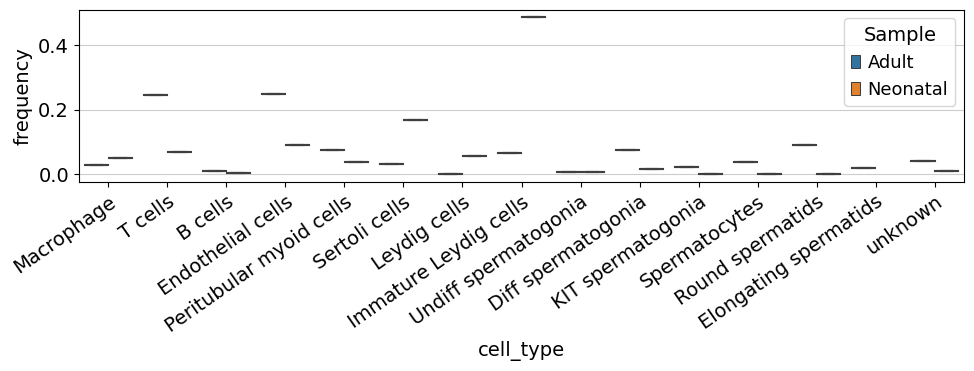

In [46]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(data = cell_type_counts,x='cell_type',y='frequency',hue='Sample')
plt.xticks(rotation=35,rotation_mode = 'anchor',ha= 'right')
plt.tight_layout()
plt.savefig('./figures/frequency.pdf',dpi=600)

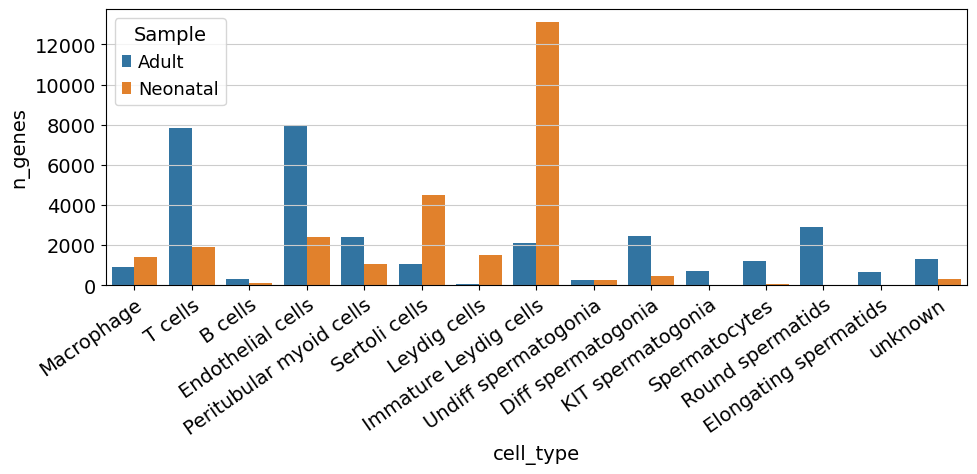

In [47]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = cell_type_counts,x='cell_type',y='n_genes',hue='Sample')
plt.xticks(rotation=35,rotation_mode = 'anchor',ha= 'right')
plt.tight_layout()
plt.savefig('./figures/barplot.pdf',dpi=600)

In [42]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['n_genes','total_counts', 'pct_counts_mt', 'pct_counts_chrX', 'pct_counts_chrY'], groupby='cell_type', rotation=90, stripplot=False, inner='box', save = "metrics1212.pdf")
sc.pl.umap(adata, color='cell_type', legend_loc='on data',
           frameon=True, legend_fontsize=10, legend_fontoutline=2,save="fig1a1212.pdf")
sc.pl.rank_genes_groups_heatmap(adata, vmin=-2, vmax=2, cmap='RdBu_r', show=False,dendrogram=False, save = "fig1dmerge1212.pdf")
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8),save='mergemarker1212.pdf')

In [46]:
sc.pl.rank_genes_groups_matrixplot(adata, use_raw=True, vmin=-3, vmax=3, cmap='bwr',save = "fig11212.pdf")

In [10]:
sc.pl.rank_genes_groups_heatmap(adata, use_raw=True, vmin=-5, vmax=5,min_logfoldchange=2,groupby='cell_type', cmap='RdBu_r', show=False,dendrogram=False, save = "fig1useraw1212.pdf")

{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:ylabel='cell_type'>,
 'gene_groups_ax': <AxesSubplot:>}

In [49]:
ax = sc.pl.correlation_matrix(adata, 'cell_type', figsize=(5,3.5), save = "merge1212.pdf")

In [50]:
marker_genes = ["TYROBP", "RGS1", "VWF", 'MYH11', "AMH", "CYP17A1",'COL3A1', 'UTF1', 'DMRT1','SOHLH1', "SYCP2", "ZCWPW1","CLGN","SPACA1","PRM1","TNP1"]
sc.pl.umap(adata, color = marker_genes, ncols=4, save="mergemks1212.pdf")

In [48]:
adata.shape

(59171, 2700)

In [62]:
adata_germ = adata[adata.obs['cell_type'].isin(['Undiff spermatogonia','Diff spermatogonia','Spermatocytes',
                                                'Round spermatids','Elongating spermatids'])].copy()
adata_germ

AnnData object with n_obs × n_vars = 11696 × 2698
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [61]:
results_file = './intergedbbknn_germsubset1212.h5ad'
adata_germ.write(results_file)

In [63]:
adata_germ.obs.cell_type

adult_AAACCCAAGATGTAGT-1         Round spermatids
adult_AAACCCAAGCCGCTTG-1         Round spermatids
adult_AAACCCAAGGCTCTAT-1       Diff spermatogonia
adult_AAACCCAAGTAAACAC-1    Elongating spermatids
adult_AAACCCAAGTGGAAGA-1    Elongating spermatids
                                    ...          
neo_TTTCCTCCACTAGTAC-1         Diff spermatogonia
neo_TTTCCTCTCACCCTGT-1         Diff spermatogonia
neo_TTTGGTTGTTCGGCCA-1         Diff spermatogonia
neo_TTTGTTGCAGGCTCTG-1         Diff spermatogonia
neo_TTTGTTGTCGCACGAC-1       Undiff spermatogonia
Name: cell_type, Length: 11696, dtype: category
Categories (5, object): ['Undiff spermatogonia', 'Diff spermatogonia', 'Spermatocytes', 'Round spermatids', 'Elongating spermatids']

In [68]:
adata.obs

Sample  n_genes  n_genes_by_counts  total_counts  \
adult_AAACCCAAGACCATTC-1     Adult     1185               1185        2223.0   
adult_AAACCCAAGACGAAGA-1     Adult      931                931        1569.0   
adult_AAACCCAAGAGCGACT-1     Adult     1266               1266        2655.0   
adult_AAACCCAAGATGTAGT-1     Adult     2978               2978        9340.0   
adult_AAACCCAAGCCGCTTG-1     Adult      628                628         759.0   
...                            ...      ...                ...           ...   
neo_TTTGTTGTCCTGTACC-1    Neonatal     1913               1913        4195.0   
neo_TTTGTTGTCGCACGAC-1    Neonatal     4454               4454       10521.0   
neo_TTTGTTGTCGCTACGG-1    Neonatal     1974               1974        7257.0   
neo_TTTGTTGTCTACTATC-1    Neonatal     1946               1946        3738.0   
neo_TTTGTTGTCTGGACTA-1    Neonatal     2786               2786        6875.0   

                          total_counts_mt  pct_counts_mt  total_counts_chrX  \
adult_AAACCCAAGACCATTC-1              0.0       0.000000               63.0   
adult_AAACCCAAGACGAAGA-1              1.0       0.063735               56.0   
adult_AAACCCAAGAGCGACT-1              1.0       0.037665               84.0   
adult_AAACCCAAGATGTAGT-1              0.0       0.000000               44.0   
adult_AAACCCAAGCCGCTTG-1              0.0       0.000000               15.0   
...                                   ...            ...                ...   
neo_TTTGTTGTCCTGTACC-1                0.0       0.000000              138.0   
neo_TTTGTTGTCGCACGAC-1                0.0       0.000000              255.0   
neo_TTTGTTGTCGCTACGG-1                0.0       0.000000              328.0   
neo_TTTGTTGTCTACTATC-1                0.0       0.000000              140.0   
neo_TTTGTTGTCTGGACTA-1                0.0       0.000000              215.0   

                          pct_counts_chrX  total_counts_chrY  pct_counts_chrY  \
adult_AAACCCAAGACCATTC-1         2.834008                3.0         0.134953   
adult_AAACCCAAGACGAAGA-1         3.569152                4.0         0.254939   
adult_AAACCCAAGAGCGACT-1         3.163842                8.0         0.301318   
adult_AAACCCAAGATGTAGT-1         0.471092                5.0         0.053533   
adult_AAACCCAAGCCGCTTG-1         1.976285                0.0         0.000000   
...                                   ...                ...              ...   
neo_TTTGTTGTCCTGTACC-1           3.289631                5.0         0.119190   
neo_TTTGTTGTCGCACGAC-1           2.423724               19.0         0.180591   
neo_TTTGTTGTCGCTACGG-1           4.519774               25.0         0.344495   
neo_TTTGTTGTCTACTATC-1           3.745318                2.0         0.053505   
neo_TTTGTTGTCTGGACTA-1           3.127273               12.0         0.174545   

                           S_score  G2M_score phase  doublet  doublet_score  \
adult_AAACCCAAGACCATTC-1  0.029769  -0.078846     S      0.0   3.945989e-54   
adult_AAACCCAAGACGAAGA-1 -0.041627   0.088205   G2M      0.0   4.205109e-95   
adult_AAACCCAAGAGCGACT-1 -0.106342   0.071795   G2M      0.0   5.867091e+01   
adult_AAACCCAAGATGTAGT-1 -0.017369   0.950641   G2M      0.0   2.749409e+01   
adult_AAACCCAAGCCGCTTG-1 -0.018204   0.008590   G2M      0.0   1.402528e-70   
...                            ...        ...   ...      ...            ...   
neo_TTTGTTGTCCTGTACC-1   -0.375308  -0.172051    G1      0.0   1.847410e-13   
neo_TTTGTTGTCGCACGAC-1   -0.183917  -0.145128    G1      0.0   3.453612e+01   
neo_TTTGTTGTCGCTACGG-1   -0.162999  -0.615513    G1      0.0   7.739418e-07   
neo_TTTGTTGTCTACTATC-1   -0.314350  -0.068590    G1      0.0   2.436721e+00   
neo_TTTGTTGTCTGGACTA-1   -0.458728  -0.084359    G1      0.0   4.272649e+01   

                         leiden                cell_type  
adult_AAACCCAAGACCATTC-1     13  Peritubular myoid cells  
adult_AAACCCAAGACGAAGA-1      0                  T cells  
adult_AAACCCAAGAGCG

In [65]:
adata.obs.cell_type

adult_AAACCCAAGACCATTC-1    Peritubular myoid cells
adult_AAACCCAAGACGAAGA-1                    T cells
adult_AAACCCAAGAGCGACT-1                    T cells
adult_AAACCCAAGATGTAGT-1           Round spermatids
adult_AAACCCAAGCCGCTTG-1           Round spermatids
                                     ...           
neo_TTTGTTGTCCTGTACC-1                 Leydig cells
neo_TTTGTTGTCGCACGAC-1         Undiff spermatogonia
neo_TTTGTTGTCGCTACGG-1                   Macrophage
neo_TTTGTTGTCTACTATC-1                 Leydig cells
neo_TTTGTTGTCTGGACTA-1                 Leydig cells
Name: cell_type, Length: 59171, dtype: category
Categories (11, object): ['Macrophage', 'T cells', 'Endothelial cells', 'Peritubular myoid cells', ..., 'Diff spermatogonia', 'Spermatocytes', 'Round spermatids', 'Elongating spermatids']

In [31]:
sc.pl.tsne(adata, color=['Sample', 'cell_type'], frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="celltypebbknnright1212.pdf")

scvi-tools 流程

In [2]:
adata = sc.read('./intergedbbknn_annotation1212.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 59171 × 2698
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
marker_genes_dict = {
    'Macrophage': ['TYROBP'],
    'T cells':['RGS1'],
    'Endothelial cells': ['VWF'],
    'Peritubular myoid cells': ['MYH11'],
    'Sertoli cells': ['AMH'],
    'Leydig cells': ['DCN'],
    'Undiff spermatogonia': ['UTF1'],
    'Diff spermatogonia':['DMRT1', 'SOHLH1'],
    'Spermatocytes':['SYCP2',],
    'Round spermatids' : ['CLGN','SPACA1'],
    'Elongating spermatids': ['PRM1','TNP1'],
}

In [6]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8),save='mergemarker1213.pdf')

In [8]:
marker_genes = ["TYROBP", "RGS1", "VWF", 'MYH11', "AMH", "DCN",'UTF1', 'DMRT1','SOHLH1', "SYCP2", "CLGN","SPACA1","PRM1","TNP1"]
sc.pl.umap(adata, color = marker_genes, ncols=7, save="mergemks1213.pdf")

In [8]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [50]:
adata

AnnData object with n_obs × n_vars = 66468 × 19094
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY'
    uns: 'log1p'
    layers: 'counts'

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="Sample"
)

In [52]:
pip install --user scikit-misc

     |████████████████████████████████| 8.8 MB 445 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [57]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["Sample"],
    continuous_covariate_keys=["pct_counts_mt"]
)

In [4]:
import scvi

Global seed set to 0
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [58]:
model = scvi.model.SCVI(adata)

In [59]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [60]:
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 1/120:   0%|                                                                                           | 0/120 [00:00<?, ?it/s]

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
import scanorama

In [8]:
import scanpy.external as sce

In [10]:
adata= sc.read('./interged_filtered_unannotation1207.h5ad')

In [11]:
adata

AnnData object with n_obs × n_vars = 59171 × 3318
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
sce.pp.scanorama_integrate(adata, 'Sample')

[[0.         0.24420408]
 [0.         0.        ]]
Processing datasets Adult <=> Neonatal


In [13]:
adata

AnnData object with n_obs × n_vars = 59171 × 3318
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:
adata.obsm['X_scanorama'].shape

(59171, 50)

In [19]:
# add to the AnnData object
adata.obsm["Scanorama"] = adata.obsm['X_scanorama']

In [20]:
sc.pp.neighbors(adata, n_pcs =50, use_rep = "Scanorama")

2022-12-11 15:01:06.581423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public/home/zhaox/anaconda3/envs/jupyter/lib:/opt/OpenBLAS/lib
2022-12-11 15:01:06.581477: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
# tsne and umap
## sc.pp.neighbors(adata, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = 50, use_rep = "Scanorama")

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [22]:
adata

AnnData object with n_obs × n_vars = 59171 × 3318
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_scanorama', 'Scanorama', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [23]:
sc.pl.umap(adata,color=['Sample', 'leiden'], legend_loc= "right margin", save= "merge1209scanorama.pdf")

重新进行Adult分析

In [62]:
adata=sc.read_h5ad('./adult_filtered_unannotation.h5ad')

In [63]:
adata

AnnData object with n_obs × n_vars = 24967 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [64]:
sc.tl.leiden(adata,resolution=1.2)

In [65]:
sc.pl.umap(adata, color='leiden',save='adultleiden.pdf')

In [8]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save="adult1214.pdf")

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFram

In [9]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
adata.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    
    {group + '_' + key: result[key][group]    
    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("./figures/diff_rank_genes_groups_adult1214.csv")

In [37]:
marker_genes_dict = {
    'Macrophage': ['TYROBP'],
    'T cells':['RGS1'],
    'Endothelial cells': ['VWF'],
    'Peritubular myoid cells': ['MYH11'],
    'Sertoli cells': ['SOX9'],
    'Leydig cells': ['DCN'],
    'Undiff spermatogonia': ['UTF1'],
    'Diff spermatogonia':['DMRT1', 'SOHLH1'],
    'Spermatocytes':['SYCP2',],
    'Round spermatids' : ['CLGN','SPACA1'],
    'Elongating spermatids': ['PRM1','TNP1'],
}

In [30]:
marker_genes_dict = {
    'Macrophage': ['CD74','TYROBP','SLA-DQB1','SLA-DRB1','SLA-DQA1'],
    'T cells':['ID2','RGS1'],
    'Endothelial cells': ['VWF', 'PECAM1','TM4SF1','CLEC3B','CDH5'],
    'Peritubular myoid cells': ['MYH11', 'MYL9','ACTA2'],
    'Sertoli cells': ['SOX9','AMH','INHA'],
    'Leydig cells': ['CYP17A1', 'CYP11A1','COL1A1','COL1A2','COL3A1','DCN'],
    'Undiff spermatogonia': ['UTF1', 'PIWIL4','UCHL1'],
    'Diff spermatogonia':['DMRT1', 'SOHLH1', 'MKI67','KIT','PIWIL2','UCHL1','STRA8'],
    'Spermatocytes':['SYCP1', 'SYCP2', 'SYCP3','SMC1B', 'TEX101', 'ZCWPW1','ADAM2'],
    'Round spermatids' : ['CLGN','DKKL1','YBX2','SPACA1'],
    'Elongating spermatids': ['PRM1', 'PRM2', 'TNP1', 'TNP2','ACRV1'],
}

In [31]:
sc.pl.dotplot(adata, marker_genes_dict, 'cell_type', use_raw= True,dendrogram=True,save="adult1214.pdf")

categories: Diff spermatogonia, Elongating spermatids, Endothelial cells, etc.
var_group_labels: Macrophage, T cells, Endothelial cells, etc.


In [ ]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8),save='mergemarker1212.pdf')

In [15]:
sc.tl.dendrogram(adata,groupby='leiden')

In [18]:
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))
sc.pl.umap(adata, color=['leiden', 'cell_type'], frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="adultcelltype1214.pdf")

In [32]:
cluster2annotation = {
     '0': 'Endothelial cells',
     '1': 'T cells',
     '2': 'T cells',
     '3': 'Peritubular myoid cells',
     '4': 'Endothelial cells',
     '5': 'T cells',
     '6': 'Elongating spermatids',
     '7': 'Round spermatids',
     '8': 'Leydig cells',
     '9': 'Endothelial cells',
     '10': 'T cells',
     '11': 'Round spermatids',
     '12': 'Macrophage',
     '13': 'unkonwn KIT',
     '14': 'T cells',
     '15': 'Endothelial cells',
     '16': 'Leydig cells',
     '17': 'Diff spermatogonia',
     '18': 'Leydig cells',
     '19': 'Undiff spermatogonia',
     '20': 'Spermatocytes',
     '21': 'Peritubular myoid cells',
     '22': 'T cells',
     '23': 'Round spermatids',
     '24': 'Macrophage',
     '25': 'Elongating spermatids',
     '26': 'Macrophage',
     '27': 'Macrophage',
     '28': 'Round spermatids',
     '29': 'unknown',     
     '30': 'Leydig cells',
     '31': 'Macrophage',
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [33]:
original_order = ['Diff spermatogonia', 'Elongating spermatids', 'Endothelial cells', 'Leydig cells','Macrophage','Peritubular myoid cells',
                 'Round spermatids','Spermatocytes','T cells', 'Undiff spermatogonia','unknown','unkonwn KIT']
adata.obs['cell_type'] = adata.obs['cell_type'].cat.set_categories(['Macrophage', 'T cells','Endothelial cells', 'Peritubular myoid cells',
                                                                    'Leydig cells', 'Undiff spermatogonia', 'Diff spermatogonia', 
                                                                    'Spermatocytes','Round spermatids','Elongating spermatids','unknown','unkonwn KIT'])

In [34]:
adata.obs.cell_type

AAACCCAAGACCATTC-1               Leydig cells
AAACCCAAGACGAAGA-1                    T cells
AAACCCAAGATGTAGT-1           Round spermatids
AAACCCAAGCCGCTTG-1           Round spermatids
AAACCCAAGGATCATA-1          Endothelial cells
                               ...           
TTTGTTGTCAGCTTGA-1                    T cells
TTTGTTGTCCGACAGC-1                    T cells
TTTGTTGTCGATGCAT-1          Endothelial cells
TTTGTTGTCGCGTTTC-1          Endothelial cells
TTTGTTGTCTGTCCCA-1    Peritubular myoid cells
Name: cell_type, Length: 24967, dtype: category
Categories (12, object): ['Macrophage', 'T cells', 'Endothelial cells', 'Peritubular myoid cells', ..., 'Round spermatids', 'Elongating spermatids', 'unknown', 'unkonwn KIT']

In [35]:
sc.pl.umap(adata, color='cell_type', frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="adultcelltyperight1214.pdf")

In [36]:
sc.tl.rank_genes_groups(adata, groupby='cell_type', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, values_to_plot='logfoldchanges',dendrogram=False, min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', save="adultnewmarkers1214.pdf")

In [38]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['n_genes','total_counts', 'pct_counts_mt', 'pct_counts_chrX', 'pct_counts_chrY'], groupby='cell_type', rotation=90, stripplot=False, inner='box', save = "adultmetrics1214.pdf")
sc.pl.umap(adata, color='cell_type', legend_loc='on data',
           frameon=True, legend_fontsize=10, legend_fontoutline=2,save="adultfig2a1214.pdf")
sc.pl.rank_genes_groups_heatmap(adata, vmin=-2, vmax=2, cmap='RdBu_r', show=False,dendrogram=False, save = "fig1dadult1214.pdf")
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8),save='adultmarker1214.pdf')

In [39]:
marker_genes = ["TYROBP", "RGS1", "VWF", 'MYH11', "DCN",'UTF1', 'DMRT1','SOHLH1', "SYCP2", "CLGN","PRM1","TNP1"]
sc.pl.umap(adata, color = marker_genes, ncols=6, save="adultmks1214.pdf")

重新注释adult数据

In [40]:
results_file = './figures/adult_reanno1214.h5ad'
adata.write(results_file)

In [41]:
adult_subsetcellcall = adata[adata.obs['cell_type'].isin(['Undiff spermatogonia','Diff spermatogonia','Spermatocytes',
                                                'Round spermatids','Elongating spermatids'])].copy()
adult_subsetcellcall

AnnData object with n_obs × n_vars = 4911 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cell_type_colors', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [42]:
adult_subsetcellcall.obs.cell_type

AAACCCAAGATGTAGT-1         Round spermatids
AAACCCAAGCCGCTTG-1         Round spermatids
AAACCCAAGGCTCTAT-1         Round spermatids
AAACCCAAGTAAACAC-1    Elongating spermatids
AAACCCAAGTGGAAGA-1    Elongating spermatids
                              ...          
TTTGGTTTCCATACTT-1         Round spermatids
TTTGTTGAGACATCAA-1         Round spermatids
TTTGTTGAGATGTTAG-1         Round spermatids
TTTGTTGAGTATGGAT-1    Elongating spermatids
TTTGTTGCATATCTCT-1         Round spermatids
Name: cell_type, Length: 4911, dtype: category
Categories (5, object): ['Undiff spermatogonia', 'Diff spermatogonia', 'Spermatocytes', 'Round spermatids', 'Elongating spermatids']

In [45]:
sc.tl.leiden(adult_subsetcellcall,resolution=1)

In [58]:
sc.pl.umap(adult_subsetcellcall, color='leiden', frameon=True, legend_loc= "on data", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="adultsubsetondata1214.pdf")

In [79]:
marker_genes_dict = {
    'SSC': ['UCHL1', 'DAZL', 'UTF1','POU5F1'],
    'Diffing SPG': ['KIT', 'MKI67','SOHLH1','DMRT1'],
    'Diffed SPG': ['STRA8'],
    'L': ['SCML1','SMC1B','ZCWPW1','HERC5'],
    'Z': ['SYCP1', 'SYCP2','SYCP3','SYCE1', 'TEX12','TEX101','PRSS50','SOD1'],
    'P': ['PIWIL1','ADAM2', 'MGAT4D','CCDC112','NME8','CCNA1','CCNA2','PROK2','MLLT10','RSPH1','YBX2'],
    'D': ['SPATA16','CCNB2', 'GYG1','ZC2HC1C','AURKA','TMIGD3','POU5F2','GGN'],
    'SPT': ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','ACRV1','SPACA1','SPACA3'],
    'Sertoli cells':['SOX9','INHA','BEX4','FATE1','CLU','AMH'],
}

In [53]:
sc.tl.dendrogram(adult_subsetcellcall,groupby="leiden")

In [80]:
sc.pl.dotplot(adult_subsetcellcall, marker_genes_dict, 'leiden', dendrogram=True,save="subset.pdf")

categories: 0, 1, 2, etc.
var_group_labels: SSC, Diffing SPG, Diffed SPG, etc.


In [97]:
cluster2annotation = {
     '0': 'S1',
     '1': 'Sertoli cells',
     '2': 'S5',
     '3': 'P2',
     '4': 'Z1',
     '5': 'L',
     '6': 'Diffed SPG',
     '7': 'S4',
     '8': 'Diffing SPG2',
     '9': 'P4',
     '10': 'P1',
     '11': 'D3',
     '12': 'S3',
     '13': 'Diffing SPG1',
     '14': 'D1',
     '15': 'P3',
     '16': 'Z2',
     '17': 'SPC11',
     '18': 'SSC',
     '19': 'D2',
     '20': 'S2',
}
adult_subsetcellcall.obs['cell_type'] = adult_subsetcellcall.obs['leiden'].map(cluster2annotation).astype('category')

In [98]:
original_order = ['S1', 'Sertoli cells', 'S5', 'P2', 'Z1','L','Diffed SPG',
                  'S4','Diffing SPG2','P4', 'P1','D3','S3','Diffing SPG1','D1','P3','Z2','SPC11', 'SSC', 'D2', 'S2']
adult_subsetcellcall.obs['cell_type'] = adult_subsetcellcall.obs['cell_type'].cat.set_categories(['SSC', 'Diffing SPG1','Diffing SPG2', 'Diffed SPG','L', 'Z1', 'Z2','P1','P2','P3','P4',
                                                                                                  'D1','D2','D3','SPC11','S1','S2','S3','S4','S5','Sertoli cells'])

In [99]:
adult_subsetcellcall.obs.cell_type

AAACCCAAGATGTAGT-1            SPC11
AAACCCAAGCCGCTTG-1               S1
AAACCCAAGGCTCTAT-1               P1
AAACCCAAGTAAACAC-1    Sertoli cells
AAACCCAAGTGGAAGA-1    Sertoli cells
                          ...      
TTTGGTTTCCATACTT-1               S1
TTTGTTGAGACATCAA-1               P4
TTTGTTGAGATGTTAG-1               P4
TTTGTTGAGTATGGAT-1               S3
TTTGTTGCATATCTCT-1               P3
Name: cell_type, Length: 4911, dtype: category
Categories (21, object): ['SSC', 'Diffing SPG1', 'Diffing SPG2', 'Diffed SPG', ..., 'S3', 'S4', 'S5', 'Sertoli cells']

In [102]:
sc.pl.umap(adult_subsetcellcall, color='cell_type', frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="celltypeadultsubsetright1214.pdf")

用于细胞通讯（cellchat，cellcall）

In [103]:
results_file = './figures/adultsubset_cellcallanno1214.h5ad'
adult_subsetcellcall.write(results_file)

In [104]:
adult_germsubset = adult_subsetcellcall[adult_subsetcellcall.obs['cell_type'].isin(['SSC', 'Diffing SPG1','Diffing SPG2', 'Diffed SPG','L', 'Z1', 'Z2','P1','P2','P3','P4',
                                                                                    'D1','D2','D3','SPC11','S1','S2','S3','S4','S5'])].copy()
adult_germsubset

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cell_type_colors', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [105]:
sc.pl.umap(adult_germsubset, color='cell_type', frameon=True, legend_loc= "right margin", legend_fontsize=10, legend_fontweight="normal", legend_fontoutline=2, save="celltypeadultgermright1214.pdf")

In [106]:
sc.tl.rank_genes_groups(adult_subsetcellcall, groupby='cell_type', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adult_subsetcellcall, n_genes=5, values_to_plot='logfoldchanges',dendrogram=False, min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', save="adultsubsetnewmarkers1214.pdf")

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFram

In [107]:
pd.DataFrame(adult_subsetcellcall.uns['rank_genes_groups']['names']).head(5)
adult_subsetcellcall.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = adult_subsetcellcall.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    
    {group + '_' + key: result[key][group]    
    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("./figures/diff_rank_genes_groups_adultsubsetcelltype1214.csv")

In [71]:
marker_genes_dict = {
    'SSC': ['UCHL1', 'DAZL', 'UTF1','ID4','GFRA1','RET','NANOS2','ZBTB16','SALL4','POU3F1','FGFR3','BMPR1B'],
    'Diffing SPG': ['KIT', 'MKI67','SOHLH1','DMRT1'],
    'Diffed SPG': ['STRA8'],
    'L': ['SCML1','SMC1B','ZCWPW1','CCNB3','HERC5','MDK'],
    'Z': ['SYCP1', 'SYCP2','SYCP3','SYCE1', 'TEX12','TEX101','PRSS50','SOD1'],
    'P': ['PIWIL1','ADAM2', 'MGAT4D','CCDC112','NME8','OVOL1','OVOL2','CCNA1','CCNA2','PROK2','MLLT10','RSPH1','CDC42EP3'],
    'D': ['SPATA16','CCNB2', 'GYG1','ZC2HC1C','MXRA8','AURKA','TMIGD3','POU5F2','GGN'],
    'SPT': ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','TXNDC2','RUNX2','SUN5','CLCN1','CLCNKA','FSIP2','ACRV1','SPACA1','SPACA3'],
    'Sertoli cells':['SOX9','INHA','BEX4','FATE1','CLU','AMH'],
}

In [108]:
marker_genes_dict = {
    'SSC': ['UCHL1', 'DAZL', 'UTF1','POU5F1'],
    'Diffing SPG': ['KIT', 'MKI67','SOHLH1','DMRT1'],
    'Diffed SPG': ['STRA8'],
    'L': ['SCML1','SMC1B','ZCWPW1','HERC5'],
    'Z': ['SYCP1', 'SYCP2','SYCP3','SYCE1', 'TEX12','TEX101','PRSS50','SOD1'],
    'P': ['PIWIL1','ADAM2', 'MGAT4D','CCDC112','NME8','CCNA1','CCNA2','PROK2','MLLT10','RSPH1','YBX2'],
    'D': ['SPATA16','CCNB2', 'GYG1','ZC2HC1C','AURKA','TMIGD3','POU5F2','GGN'],
    'SPT': ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','ACRV1','SPACA1','SPACA3'],
}

In [116]:
sc.tl.dendrogram(adult_germsubset,groupby='cell_type')

In [115]:
sc.tl.rank_genes_groups(adult_germsubset,groupby='cell_type', method='wilcoxon')

In [117]:
sc.pl.rank_genes_groups_heatmap(adult_germsubset, use_raw=True, vmin=-5, vmax=5,min_logfoldchange=2,groupby='cell_type', cmap='RdBu_r', show=False,dendrogram=False, save = "fig2userawgermsubset1214.pdf")

{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:ylabel='cell_type'>,
 'gene_groups_ax': <AxesSubplot:>}

In [140]:
cell_cycle_genes = [x.strip() for x in open('./cell_cycle_genes (remove).txt')]

In [141]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [144]:
ax = sc.pl.heatmap(adult_germsubset,g2m_genes, groupby=['cell_type'], vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False,show_gene_labels=False, swap_axes=True, figsize=(11,8), save = "subsetgermcellcycleg2mgenes1214.pdf")

用于轨迹分析

In [145]:
results_file = './figures/adultsubsetgerm1214.h5ad'
adult_germsubset.write(results_file)

In [113]:
ax = sc.pl.heatmap(adult_germsubset, marker_genes_dict, groupby='cell_type', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=False, swap_axes=True, figsize=(11,8), save = "subsetgermcelltypemarker.pdf")

In [47]:
sc.tl.rank_genes_groups(adult_subsetcellcall, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adult_subsetcellcall, n_genes=5, values_to_plot='logfoldchanges',dendrogram=False, min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr', save="adultnewmarkers1214.pdf")

/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFram

#### palantir (Characterization of cell fate probabilities in single-cell data with Palantir)

In [4]:
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [6]:
adata_germsubset = sc.read("./figures/adultsubsetgerm1214.h5ad")
adata_germsubset

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Principal component analysis
## The first step in data processing for Palantir is to determine metagenes using principal component analysis. 
## This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data

In [7]:
pca_projections, _ = palantir.utils.run_pca(adata_germsubset)

## Diffusion maps
## Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [8]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


2022-12-15 10:35:03.007968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public/home/zhaox/anaconda3/envs/jupyter/lib:/opt/OpenBLAS/lib
2022-12-15 10:35:03.008030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The low dimensional embeddeing of the data is estimated based on the eigen gap using the following function

In [9]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

## tSNE visualization
## Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories

In [10]:
tsne = palantir.utils.run_tsne(ms_data)

Using the 'MulticoreTSNE' package by Ulyanov (2017)


In [15]:
fig, ax = palantir.plot.plot_tsne(tsne)
plt.savefig('./figures/palantir_tsne.pdf')

In [27]:
counts = pd.DataFrame(data=adata_germsubset.X.todense(),index=adata_germsubset.obs_names,columns=adata_germsubset.var_names)

In [82]:
germsubset_geneexp = pd.DataFrame(data=adata_germsubset.X.todense().T, index=adata_germsubset.var_names,columns=adata_germsubset.obs_names)

In [87]:
germsubset_geneexp.to_csv('./figures/germsubset_geneexp.csv')

In [88]:
meta=pd.DataFrame(data=adata_germsubset.obs)
meta

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGATGTAGT-1     2978               2978        9340.0              0.0   
AAACCCAAGCCGCTTG-1      628                628         759.0              0.0   
AAACCCAAGGCTCTAT-1      840                840        1282.0              1.0   
AAACCCAGTCCAGGTC-1      977                977        1252.0              0.0   
AAACCCAGTTCGGCGT-1      999                999        1945.0              2.0   
...                     ...                ...           ...              ...   
TTTGGTTTCCATACTT-1      570                570         648.0              0.0   
TTTGTTGAGACATCAA-1      541                541         628.0              0.0   
TTTGTTGAGATGTTAG-1     1735               1735        2776.0              0.0   
TTTGTTGAGTATGGAT-1     2744               2744        6329.0              4.0   
TTTGTTGCATATCTCT-1     1521               1521        2394.0              0.0   

                    pct_counts_mt  total_counts_chrX  pct_counts_chrX  \
AAACCCAAGATGTAGT-1       0.000000               44.0         0.471092   
AAACCCAAGCCGCTTG-1       0.000000               15.0         1.976285   
AAACCCAAGGCTCTAT-1       0.078003               32.0         2.496100   
AAACCCAGTCCAGGTC-1       0.000000               34.0         2.715655   
AAACCCAGTTCGGCGT-1       0.102828               69.0         3.547558   
...                           ...                ...              ...   
TTTGGTTTCCATACTT-1       0.000000                6.0         0.925926   
TTTGTTGAGACATCAA-1       0.000000                5.0         0.796178   
TTTGTTGAGATGTTAG-1       0.000000               42.0         1.512968   
TTTGTTGAGTATGGAT-1       0.063201              172.0         2.717649   
TTTGTTGCATATCTCT-1       0.000000               25.0         1.044277   

                    total_counts_chrY  pct_counts_chrY   S_score  G2M_score  \
AAACCCAAGATGTAGT-1                5.0         0.053533 -0.123151   0.865459   
AAACCCAAGCCGCTTG-1                0.0         0.000000 -0.002305  -0.004789   
AAACCCAAGGCTCTAT-1                4.0         0.312012  0.015211   0.010102   
AAACCCAGTCCAGGTC-1                1.0         0.079872  0.353405   0.146663   
AAACCCAGTTCGGCGT-1                1.0         0.051414 -0.106809   0.184900   
...                               ...              ...       ...        ...   
TTTGGTTTCCATACTT-1                0.0         0.000000 -0.066667   0.012721   
TTTGTTGAGACATCAA-1                2.0         0.318471  0.015546   0.076025   
TTTGTTGAGATGTTAG-1                6.0         0.216138 -0.105845   0.120024   
TTTGTTGAGTATGGAT-1               14.0         0.221204 -0.510748  -0.328494   
TTTGTTGCATATCTCT-1                0.0         0.000000 -0.087995   0.106854   

                   phase  doublet  doublet_score leiden     cell_type  
AAACCCAAGATGTAGT-1   G2M      0.0   4.674769e+00     17         SPC11  
AAACCCAAGCCGCTTG-1    G1      0.0   7.041683e-65      0            S1  
AAACCCAAGGCTCTAT-1     S      0.0   7.866119e-02     10            P1  
AAACCCAGTCCAGGTC-1     S      0.0   3.043958e-02      8  Diffing SPG2  
AAACCCAGTTCGGCGT-1   G2M      0.0   7.866119e-02     10            P1  
...                  ...      ...            ...    ...           ...  
TTTGGTTTCCATACTT-1   G2M      0.0   3.041393e-14      0            S1  
TTTGTTGAGACATCAA-1   G2M      0.0   1.460851e-22      9            P4  
TTTGTTGAGATGTTAG-1   G2M      0.0   3.333309e+01      9            P4  
TTTGTTGAGTATGGAT-1    G1      0.0   1.192613e+00     12            S3  
TTTGTTGCATATCTCT-1   G2M      0.0   3.784071e-04     15            P3  

[4484 rows x 16 columns]

In [89]:
meta.to_csv('./figures/germsubset_metadata.csv') 

In [26]:
from scipy.sparse import csr_matrix
adata_germsubset.X = csr_matrix(adata_germsubset.X)

In [28]:
fig, ax = palantir.plot.plot_tsne_by_cell_sizes(counts, tsne)
plt.savefig('./figures/palantir_counts.pdf')

In [90]:
adata_germsubset

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## MAGIC imputation
## MAGIC is an imputation technique developed in the Pe'er lab for single cell data imputation. 
## Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [29]:
imp_df = palantir.utils.run_magic_imputation(adata_germsubset, dm_res)

## Gene expression can be visualized on tSNE maps using the plot_gene_expression function. 
## The genes parameter is an string iterable of genes, which are a subset of the expression of column names. 

In [108]:
marker_genes_dict = {
    'SSC': ['UCHL1', 'DAZL', 'UTF1','POU5F1'],
    'Diffing SPG': ['KIT', 'MKI67','SOHLH1','DMRT1'],
    'Diffed SPG': ['STRA8'],
    'L': ['SCML1','SMC1B','ZCWPW1','HERC5'],
    'Z': ['SYCP1', 'SYCP2','SYCP3','SYCE1', 'TEX12','TEX101','PRSS50','SOD1'],
    'P': ['PIWIL1','ADAM2', 'MGAT4D','CCDC112','NME8','CCNA1','CCNA2','PROK2','MLLT10','RSPH1','YBX2'],
    'D': ['SPATA16','CCNB2', 'GYG1','ZC2HC1C','AURKA','TMIGD3','POU5F2','GGN'],
    'SPT': ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','ACRV1','SPACA1','SPACA3'],
}

In [33]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['UTF1', 'SOHLH1', 'ZCWPW1', 'TEX101', 'ADAM2','ACRV1','SPACA1','TMIGD3', 'PRM1', 'TNP1'])

In [34]:
plt.savefig('./figures/palantir_geneexpression.pdf')

## Diffusion maps
## The computed diffusion components can be visualized with the following snippet.

In [35]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

In [36]:
plt.savefig('./figures/palantir_diffusioncomponents.pdf')

## Running Palantir
## Palantir can be run by specifying an approxiate early cell. 
## While Palantir automatically determines the terminal states, they can also specified using the termine_states parameter.

In [43]:
adata_germsubset.obs['cell_type']

AAACCCAAGATGTAGT-1           SPC11
AAACCCAAGCCGCTTG-1              S1
AAACCCAAGGCTCTAT-1              P1
AAACCCAGTCCAGGTC-1    Diffing SPG2
AAACCCAGTTCGGCGT-1              P1
                          ...     
TTTGGTTTCCATACTT-1              S1
TTTGTTGAGACATCAA-1              P4
TTTGTTGAGATGTTAG-1              P4
TTTGTTGAGTATGGAT-1              S3
TTTGTTGCATATCTCT-1              P3
Name: cell_type, Length: 4484, dtype: category
Categories (20, object): ['SSC', 'Diffing SPG1', 'Diffing SPG2', 'Diffed SPG', ..., 'S2', 'S3', 'S4', 'S5']

In [74]:
# Determine the boundary cell closest to user defined early cell
data = ms_data
dm_boundaries = pd.Index(set(data.idxmax()).union(data.idxmin()))
dists = pairwise_distances(
        data.loc[dm_boundaries, :], data.loc[early_cell, :].values.reshape(1, -1)
    )
start_cell = pd.Series(np.ravel(dists), index=dm_boundaries).idxmin()

NameError: name 'pairwise_distances' is not defined

In [56]:
data = ms_data
dm_boundaries = pd.Index(set(data.idxmax()).union(data.idxmin()))
dm_boundaries

Index(['AGTTCCCAGCCTCAAT-1', 'TGGGCTGCATGAAAGT-1', 'TCACGCTCATCGGAGA-1',
       'CCGTAGGCACTAAACC-1'],
      dtype='object')

In [78]:
palantir.plot.highlight_cells_on_tsne(tsne, 'TGGGCTGCATGAAAGT-1')

(<Figure size 200x200 with 1 Axes>, <AxesSubplot:>)

In [79]:
plt.savefig('./figures/palantir_terminal1.pdf')

In [76]:
start_cell = 'AGTTCCCAGCCTCAAT-1'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.006402929623921712 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back t

Time for shortest paths: 0.18506286144256592 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...


/public/home/zhaox/anaconda3/lib/python3.9/site-packages/palantir/core.py:379: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = [pseudotime[i].idxmax() for i in nx.connected_components(graph)]
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/palantir/core.py:379: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cells = [pseudotime[i].idxmax() for i in nx.connected_components(graph)]


Computing fundamental matrix and absorption probabilities...


/public/home/zhaox/anaconda3/lib/python3.9/site-packages/palantir/core.py:447: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ent = ent.append(pd.Series(0, index=terminal_states))
/public/home/zhaox/anaconda3/lib/python3.9/site-packages/palantir/core.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  branch_probs = branch_probs.append(bp.loc[:, branch_probs.columns])


Project results to all cells...


In [77]:
pr_res.branch_probs.columns

Index(['CCGTAGGCACTAAACC-1', 'TGGGCTGCATGAAAGT-1'], dtype='object')

## Visualizing Palantir results
## Palantir results can be visualized on the tSNE map using the plot_palantir_results function

In [68]:
palantir.plot.plot_palantir_results(pr_res, tsne)

In [69]:
plt.savefig('./figures/palantir_resultsstart01.pdf')

In [80]:
pip install CytoTRACE

ERROR: Could not find a version that satisfies the requirement CytoTRACE (from versions: none)
ERROR: No matching distribution found for CytoTRACE
Note: you may need to restart the kernel to use updated packages.


## scvelo

In [39]:
import scvelo as scv
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.4 (python 3.9.7) on 2022-12-17 15:19.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [40]:
adata = sc.read('./figures/adultsubsetgerm1214.h5ad')
adata

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [41]:
adata

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [42]:
cluster2annotation = {
     '0': 'Spermatids',
     '2': 'Spermatids',
     '3': 'P',
     '4': 'Z',
     '5': 'L',
     '6': 'Diffed SPG',
     '7': 'Spermatids',
     '8': 'Diffing SPG',
     '9': 'P',
     '10': 'P',
     '11': 'D',
     '12': 'Spermatids',
     '13': 'Diffing SPG',
     '14': 'D',
     '15': 'P',
     '16': 'Z',
     '17': 'SPC11',
     '18': 'SSC',
     '19': 'D',
     '20': 'Spermatids',
}
adata.obs['cell_type_subsetcellcall'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [43]:
original_order = ['D', 'Diffed SPG', 'Diffing SPG', 'L', 'P','SPC11', 'SSC', 'Spermatids', 'Z']
adata.obs['cell_type_subsetcellcall'] = adata.obs['cell_type_subsetcellcall'].cat.set_categories(['SSC', 'Diffing SPG', 'Diffed SPG','L', 'Z', 'P','D','SPC11','Spermatids'])

In [44]:
adata.obs.cell_type_subsetcellcall

AAACCCAAGATGTAGT-1          SPC11
AAACCCAAGCCGCTTG-1     Spermatids
AAACCCAAGGCTCTAT-1              P
AAACCCAGTCCAGGTC-1    Diffing SPG
AAACCCAGTTCGGCGT-1              P
                         ...     
TTTGGTTTCCATACTT-1     Spermatids
TTTGTTGAGACATCAA-1              P
TTTGTTGAGATGTTAG-1              P
TTTGTTGAGTATGGAT-1     Spermatids
TTTGTTGCATATCTCT-1              P
Name: cell_type_subsetcellcall, Length: 4484, dtype: category
Categories (9, object): ['SSC', 'Diffing SPG', 'Diffed SPG', 'L', ..., 'P', 'D', 'SPC11', 'Spermatids']

In [11]:
adata_loom = scv.read('./Adult/Adult.loom', cache=True)
adata_loom

AnnData object with n_obs × n_vars = 38447 × 20894
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [12]:
scv.pl.proportions(adata_loom,save="./figures/proportions.pdf")

saving figure to file ./figures/proportions.pdf


## 合并已处理的adata文件与loom文件

In [45]:
adata = scv.utils.merge(adata, adata_loom)

In [46]:
adata

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type', 'cell_type_subsetcellcall', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances

In [47]:
scv.pl.proportions(
    adata,
    groupby='cell_type_subsetcellcall',
    layers=None,
    highlight='unspliced',
    add_labels_pie=True,
    add_labels_bar=True,
    fontsize=8,
    figsize=(15, 2),
    dpi=600,
    use_raw=True,
    show=True,
    save="./figures/germspliced.pdf",
)

saving figure to file ./figures/germspliced.pdf


In [49]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 391 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [50]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [51]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/24 cores)


  0%|          | 0/4484 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [52]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cell_type_subsetcellcall',save='basicsubset.pdf')

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_basicsubset.pdf


In [55]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=600,color='cell_type_subsetcellcall',legend_loc='right margin',save='subsetvelocity.pdf')

saving figure to file ./figures/scvelo_subsetvelocity.pdf


## Now, let us examine the phase portraits of some marker genes, 
## visualized with scv.pl.velocity(adata, gene_names) or scv.pl.scatter(adata, gene_names).

In [108]:
marker_genes_dict = {
    'SSC': ['UCHL1', 'DAZL', 'UTF1','POU5F1'],
    'Diffing SPG': ['KIT', 'MKI67','SOHLH1','DMRT1'],
    'Diffed SPG': ['STRA8'],
    'L': ['SCML1','SMC1B','ZCWPW1','HERC5'],
    'Z': ['SYCP1', 'SYCP2','SYCP3','SYCE1', 'TEX12','TEX101','PRSS50','SOD1'],
    'P': ['PIWIL1','ADAM2', 'MGAT4D','CCDC112','NME8','CCNA1','CCNA2','PROK2','MLLT10','RSPH1','YBX2'],
    'D': ['SPATA16','CCNB2', 'GYG1','ZC2HC1C','AURKA','TMIGD3','POU5F2','GGN'],
    'SPT': ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','ACRV1','SPACA1','SPACA3'],
}

In [72]:
scv.pl.velocity(adata,['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPATA3','CCIN','ACRV1','SPACA1'], dpi=600, color='cell_type_subsetcellcall', ncols=2,save='spermatidsmarkergenes.pdf')

saving figure to file ./figures/scvelo_spermatidsmarkergenes.pdf


In [62]:
scv.pl.velocity(adata, ['KIT', 'MKI67','SOHLH1','DMRT1'], dpi=600, color='cell_type_subsetcellcall',legend_loc='right',ncols=2,save='diffingmarkergenes.pdf')

saving figure to file ./figures/scvelo_diffingmarkergenes.pdf


In [73]:
adata_cellcall = sc.read('./figures/adultsubset_cellcallanno1214.h5ad')
adata_cellcall

AnnData object with n_obs × n_vars = 4911 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [78]:
obs = adata_cellcall.obs
var = adata_cellcall.var

In [79]:
from scipy.sparse import csr_matrix
adata_cellcall.X = csr_matrix(adata_cellcall.X)
mtx =  adata_cellcall.X.todense()

In [80]:
mtx

matrix([[ 1.8694692 ,  2.6133585 ,  3.0646446 , ...,  2.1183143 ,
          1.9709158 , -0.27459514],
        [-0.15584908, -0.12196989, -0.3486088 , ..., -0.1418578 ,
         -0.24067968, -0.06216916],
        [-0.17509642, -0.14021592,  3.236342  , ..., -0.14057605,
         -0.22176081, -0.0851322 ],
        ...,
        [-0.24030069, -0.20104325, -0.47479084, ..., -0.2394666 ,
         -0.41734406, -0.09515277],
        [ 3.157943  , -0.11255635,  1.2788495 , ..., -0.06599809,
         -0.1756672 , -0.05347127],
        [-0.22682504, -0.18812513, -0.4601126 , ...,  6.162005  ,
         -0.3940012 , -0.09023525]], dtype=float32)

## Dynamical Model
## We run the dynamical model to learn the full transcriptional dynamics of splicing kinetics.

In [17]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/24 cores)


  0%|          | 0/2851 [00:00<?, ?gene/s]

    finished (0:16:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [32]:
scv.tl.velocity(adata, mode='stochastic',enforce=True)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [33]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/24 cores)


  0%|          | 0/4484 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [22]:
adata.write('./figures/adultsubsetgermrunned_dynamical.h5ad', compression='gzip')
## adata = scv.read('./figures/adultsubsetgermrunned_dynamical.h5ad')

In [24]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGATGTAGT     2978               2978        9340.0              0.0   
AAACCCAAGCCGCTTG      628                628         759.0              0.0   
AAACCCAAGGCTCTAT      840                840        1282.0              1.0   
AAACCCAGTCCAGGTC      977                977        1252.0              0.0   
AAACCCAGTTCGGCGT      999                999        1945.0              2.0   
...                   ...                ...           ...              ...   
TTTGGTTTCCATACTT      570                570         648.0              0.0   
TTTGTTGAGACATCAA      541                541         628.0              0.0   
TTTGTTGAGATGTTAG     1735               1735        2776.0              0.0   
TTTGTTGAGTATGGAT     2744               2744        6329.0              4.0   
TTTGTTGCATATCTCT     1521               1521        2394.0              0.0   

                  pct_counts_mt  total_counts_chrX  pct_counts_chrX  \
AAACCCAAGATGTAGT       0.000000               44.0         0.471092   
AAACCCAAGCCGCTTG       0.000000               15.0         1.976285   
AAACCCAAGGCTCTAT       0.078003               32.0         2.496100   
AAACCCAGTCCAGGTC       0.000000               34.0         2.715655   
AAACCCAGTTCGGCGT       0.102828               69.0         3.547558   
...                         ...                ...              ...   
TTTGGTTTCCATACTT       0.000000                6.0         0.925926   
TTTGTTGAGACATCAA       0.000000                5.0         0.796178   
TTTGTTGAGATGTTAG       0.000000               42.0         1.512968   
TTTGTTGAGTATGGAT       0.063201              172.0         2.717649   
TTTGTTGCATATCTCT       0.000000               25.0         1.044277   

                  total_counts_chrY  pct_counts_chrY   S_score  ...  doublet  \
AAACCCAAGATGTAGT                5.0         0.053533 -0.123151  ...      0.0   
AAACCCAAGCCGCTTG                0.0         0.000000 -0.002305  ...      0.0   
AAACCCAAGGCTCTAT                4.0         0.312012  0.015211  ...      0.0   
AAACCCAGTCCAGGTC                1.0         0.079872  0.353405  ...      0.0   
AAACCCAGTTCGGCGT                1.0         0.051414 -0.106809  ...      0.0   
...                             ...              ...       ...  ...      ...   
TTTGGTTTCCATACTT                0.0         0.000000 -0.066667  ...      0.0   
TTTGTTGAGACATCAA                2.0         0.318471  0.015546  ...      0.0   
TTTGTTGAGATGTTAG                6.0         0.216138 -0.105845  ...      0.0   
TTTGTTGAGTATGGAT               14.0         0.221204 -0.510748  ...      0.0   
TTTGTTGCATATCTCT                0.0         0.000000 -0.087995  ...      0.0   

                 doublet_score  leiden     cell_type cell_type_subsetcellcall  \
AAACCCAAGATGTAGT  4.674769e+00      17         SPC11                    SPC11   
AAACCCAAGCCGCTTG  7.041683e-65       0            S1               Spermatids   
AAACCCAAGGCTCTAT  7.866119e-02      10            P1                        P   
AAACCCAGTCCAGGTC  3.043958e-02       8  Diffing SPG2              Diffing SPG   
AAACCCAGTTCGGCGT  7.866119e-02      10            P1                        P   
...                        ...     ...           ...                      ...   
TTTGGTTTCCATACTT  3.041393e-14       0            S1               Spermatids   
TTTGTTGAGACATCAA  1.460851e-22       9            P4                        P   
TTTGTTGAGATGTTAG  3.333309e+01       9            P4                        P   
TTTGTTGAGTATGGAT  1.192613e+00      12            S3               Spermatids   
TTTGTTGCATATCTCT  3.784071e-04      15            P3                        P   

                 initial_size_spliced initial_size_unspliced  initial_size  \
AAACCCAAGATGTAGT                 8930                    850        8930.0   
AAACCCAAGCCGCTTG                  706                    497         706.0   
AAACCCAAGGCTCTAT                 1220           

In [34]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color= "cell_type_subsetcellcall",legend_loc= "right", dpi= 600, save= "adultsubsetgerm_dynamical.pdf")

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_adultsubsetgerm_dynamical.png


In [35]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

fit_alpha  fit_beta  fit_gamma         fit_t_  fit_scaling  \
LOC100125545   0.050000  0.050000   0.050000     367.843149     1.650000   
TBP            0.000013  0.000009   0.000005  228208.579708     0.901491   
TCTE3         18.171019  4.390461   0.666377       1.165630     0.435042   
WDR27          0.915063  0.245588   0.168607       3.822072     4.410077   
KIF25          7.445841  2.825826   0.700376       1.099546     0.334613   

              fit_std_u  fit_std_s  fit_likelihood  fit_u0  fit_s0  \
LOC100125545   1.000000   1.000000    0.000000e+00     0.0     0.0   
TBP            0.620000   0.324962    5.509755e-11     0.0     0.0   
TCTE3          0.769244   3.063417    2.454334e-02     0.0     0.0   
WDR27          1.761313   0.481479    4.069593e-02     0.0     0.0   
KIF25          0.690145   0.974539    1.565538e-01     0.0     0.0   

              fit_pval_steady  fit_steady_u  fit_steady_s  fit_variance  \
LOC100125545         1.000000      0.000000      0.000000  2.019484e-28   
TBP                  0.427344      2.137931      2.000000  5.453673e-01   
TCTE3                0.497572      3.275862      8.396552  4.324784e-01   
WDR27                0.475379      4.982759      2.137931  1.716884e+00   
KIF25                0.497588      3.017241      3.275862  0.000000e+00   

              fit_alignment_scaling    fit_r2  
LOC100125545              20.000000 -0.024090  
TBP                    54095.074813 -0.282950  
TCTE3                      0.777473 -0.009682  
WDR27                      1.197971 -0.594850  
KIF25                      0.449735  0.098671

In [36]:
plt.savefig("./figures/Kineticrateparamters.pdf")

## Latent time
## The dynamical model recovers the latent time of the underlying cellular processes. 
## This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, 
## based only on its transcriptional dynamics.

In [37]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, save= "./figures/adultsubsetgermlatent.pdf")

computing latent time using root_cells as prior
    finished (0:00:04) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/adultsubsetgermlatent.pdf


In [10]:
adata = sc.read("./figures/adultsubsetgerm1214.h5ad")
adata

AnnData object with n_obs × n_vars = 4484 × 2851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
adata.write("./figures/adultsubsetgerm1214.h5ad")

In [13]:
??adata.write

Signature:
adata.write(
    filename: Optional[os.PathLike] = None,
    compression: Optional[Literal['gzip', 'lzf']] = None,
    compression_opts: Union[int, Any] = None,
    force_dense: Optional[bool] = None,
    as_dense: Sequence[str] = (),
)
Source:   
    def write_h5ad(
        self,
        filename: Optional[PathLike] = None,
        compression: Optional[Literal["gzip", "lzf"]] = None,
        compression_opts: Union[int, Any] = None,
        force_dense: Optional[bool] = None,
        as_dense: Sequence[str] = (),
    ):
        """\
        Write `.h5ad`-formatted hdf5 file.

        .. note::
           Setting compression to `'gzip'` can save disk space
           but will slow down writing and subsequent reading.
           Prior to v0.6.16, this was the default for parameter `compression`.

        Generally, if you have sparse data that are stored as a dense matrix,
        you can dramatically improve performance and reduce disk space
        by converting to a :clas